In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg

import torchvision.transforms.functional as TF

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
# 1533697a23fb7953f1c0a399557991f3
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset'
od.download(dataset_url, force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gajamnithin
Your Kaggle Key: ··········


100%|██████████| 8.16G/8.16G [00:51<00:00, 170MB/s]


In [ ]:
img_dir = '/content/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/'
img_list = os.listdir(img_dir)
print(len(img_list))
valid_ratio = 0.8

31783


In [ ]:
class ImageData(Dataset):
    def __init__(self,is_train=True):
        self.is_train = is_train
        self.transform = transforms.Compose([transforms.ToTensor(),])
        self.train_index = int(valid_ratio * len(img_list))
        self.crop = transforms.CenterCrop((218,178))
    def __len__(self):
        if self.is_train:
            return self.train_index
        else:
            return len(img_list) - self.train_index -1
    def __getitem__(self, index):
        if not self.is_train:
            index = self.train_index + index
        img = mpimg.imread(img_dir+img_list[index])
        img = self.crop(TF.to_pil_image(img))
        img = self.transform(img)
        img = (img-0.5) /0.5
        return img

In [ ]:
batch_size=20
dataset = ImageData()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = 'cuda'

torch.Size([3, 218, 178])


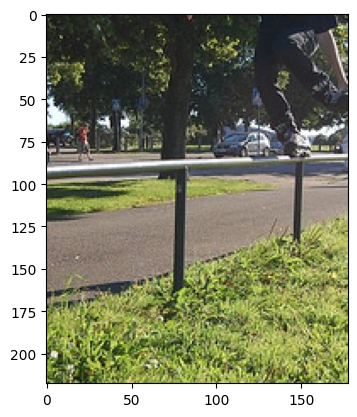

In [ ]:
a = next(iter(dataloader))
print(a[0].shape)
img = a[15]
img = img *0.5 + 0.5
plt.imshow(img.permute(1,2,0))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
IMG_WIDTH = 178
IMG_HEIGHT = 218
latent_size = 200

num_channels_in_encoder = 8

In [ ]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # ENCODER

        # 64x64x64
        self.e_conv_1 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(2, 2)),nn.LeakyReLU()
        )

        # 128x32x32
        self.e_conv_2 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2)),
            nn.LeakyReLU()
        )
        
        # 128x32x32
        self.e_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 32x32x32
        self.e_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=num_channels_in_encoder, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.Tanh()
        )
    def forward(self, x):
        ec1 = self.e_conv_1(x)
        ec2 = self.e_conv_2(ec1)
        eblock1 = self.e_block_1(ec2) + ec2
        eblock2 = self.e_block_2(eblock1) + eblock1
        eblock3 = self.e_block_3(eblock2) + eblock2
        ec3 = self.e_conv_3(eblock3)  # in [-1, 1] from tanh activation
        return ec3

In [ ]:
device

'cuda'

In [ ]:
netE = Encoder().to(device)
netE.apply(weights_init)
inp = torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100)
inp = inp.view((-1,3,IMG_HEIGHT,IMG_WIDTH))
output = netE(inp.to(device))
print(output.shape)
print('The Compression Ratio is :  ' + str((output.shape[1]*output.shape[2]*output.shape[3])/(IMG_WIDTH*IMG_HEIGHT*3)))

torch.Size([100, 8, 54, 44])
The Compression Ratio is :  6.124368686868687


In [ ]:
# Generator / Decoder Model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # DECODER

        self.d_up_conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=num_channels_in_encoder, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=(2, 2), stride=(2, 2))
        )

        # 128x64x64
        self.d_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 256x128x128
        self.d_up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=32, out_channels=128, kernel_size=(2, 2), stride=(2, 2))
        )

        # 3x128x128
        self.d_up_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((3, 3, 3, 3)),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3, 3), stride=(1, 1)),
            nn.Tanh()
        )

        
        
    def forward(self, x):
        uc1 = self.d_up_conv_1(x)
        dblock1 = self.d_block_1(uc1) + uc1
        dblock2 = self.d_block_2(dblock1) + dblock1
        dblock3 = self.d_block_3(dblock2) + dblock2
        uc2 = self.d_up_conv_2(dblock3)
        dec = self.d_up_conv_3(uc2)
        return dec

In [ ]:
netG = Generator().to(device)
netG.apply(weights_init)
inp = torch.randn(100*num_channels_in_encoder*54*44).view((-1,num_channels_in_encoder,54,44)).to(device)
output = netG(inp)
print(output.shape)
#218 * 178

torch.Size([100, 3, 218, 178])


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.latent_layer1 = nn.Sequential(
            nn.ConvTranspose2d(num_channels_in_encoder, 12, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer2 = nn.Sequential(
            nn.ConvTranspose2d(12, 16, (3,3), stride=1, padding=2, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer3 = nn.Sequential(
            nn.ConvTranspose2d(16, 24, (3,3), stride=2, padding=2, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer4 = nn.Sequential(
            nn.ConvTranspose2d(24, 36, (5,5), stride=2, padding=0, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer5 = nn.Sequential(
            nn.ConvTranspose2d(36, 3, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Tanh(),
        )

        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,stride = 2,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3,stride = 2,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3,stride = 1,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(8*54*44,2000),
            nn.Sigmoid(),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2000,100),
            nn.Sigmoid(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(100,1),
            nn.Sigmoid(),
        )
        
        
    def forward(self, x):
        y = x['encoded'].to(device)
        y = self.latent_layer1(y)
        y = self.latent_layer2(y)
        y = self.latent_layer3(y)
        y = self.latent_layer4(y)
        y = self.latent_layer5(y)
#         print(y.shape)
        x = x['img'].to(device)
#         print(x.shape)
        x = torch.cat((x,y),1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
#         print(x.shape)
        x= x.reshape((x.shape[0],-1))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
netD = Discriminator().to(device)
netD.apply(weights_init)
inp_x = {}
inp_x['img']=torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100).view((-1,3,IMG_HEIGHT,IMG_WIDTH))
inp_x['encoded'] = torch.randn(100*num_channels_in_encoder*54*44).view((-1,num_channels_in_encoder,54,44))
output = netD(inp_x)
output.shape

In [ ]:
lr = 0.0002
# Initialize BCELoss function
criterion = nn.BCELoss()
msecriterion = nn.MSELoss()
l1criterion = nn.L1Loss()
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerE = optim.Adam(netE.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
valid_dataset = ImageData(is_train=False)
num_images_to_show = 1
valid_dataloader = DataLoader(valid_dataset, batch_size=num_images_to_show, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

Starting Training Loop...
[0/7][0/1272]	Loss_D: 1.3907	Loss_G: 2.7424	Loss_E: 2.7435	D(x): 0.5366	D(G(z)): 0.5366 / 0.4644


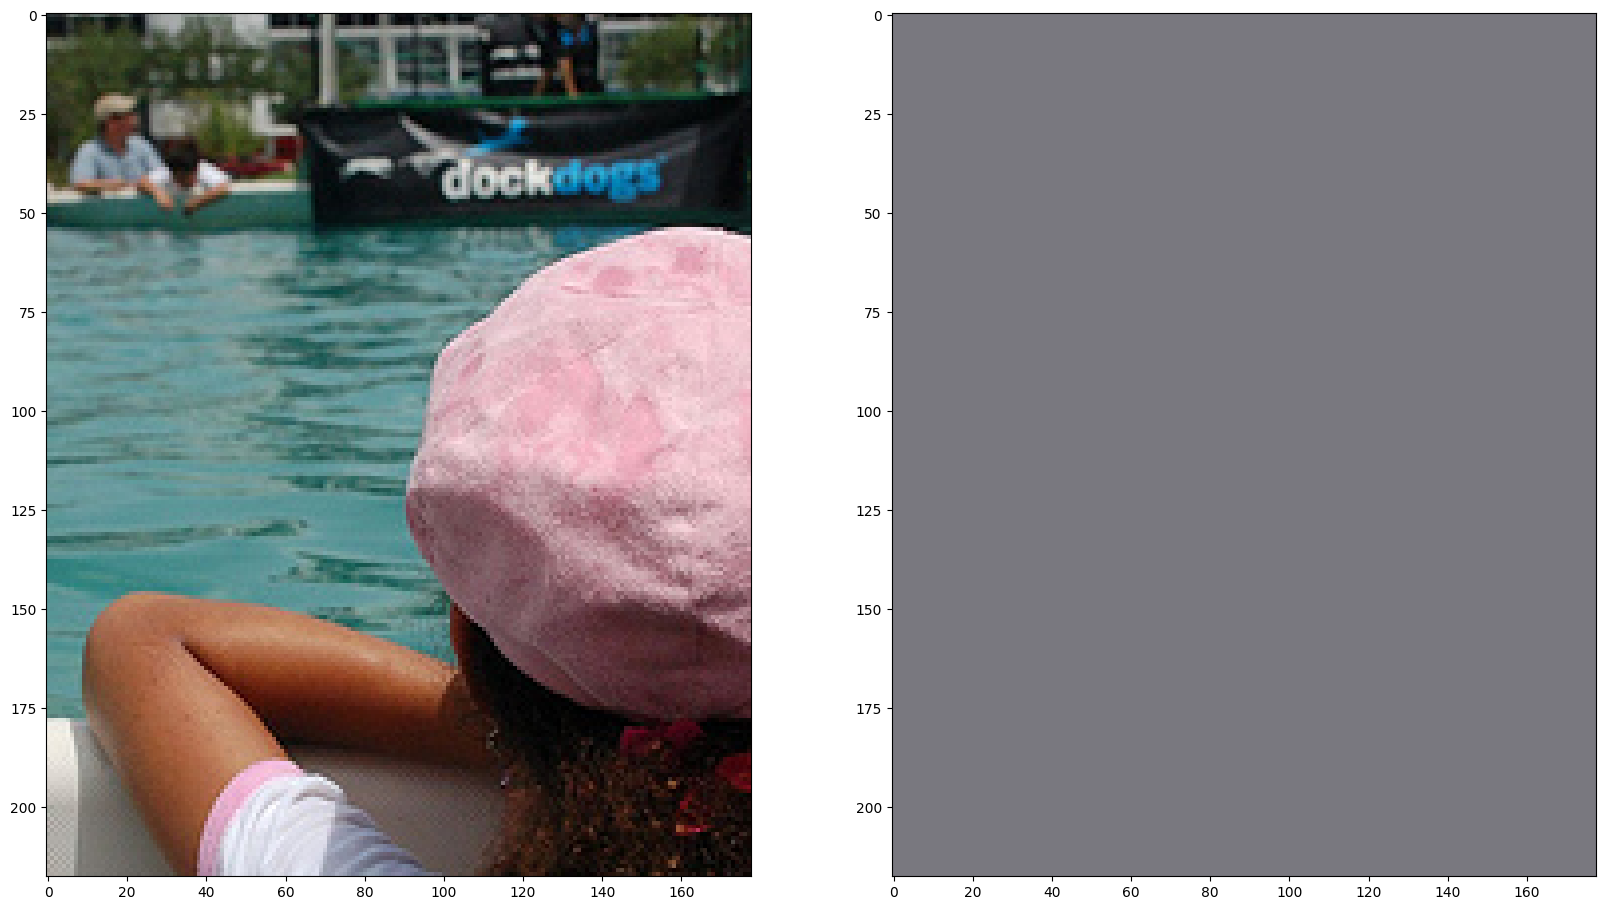

[0/7][50/1272]	Loss_D: 1.3352	Loss_G: 1.6632	Loss_E: 1.6595	D(x): 0.5220	D(G(z)): 0.4865 / 0.5122
[0/7][100/1272]	Loss_D: 1.3769	Loss_G: 1.8029	Loss_E: 1.8032	D(x): 0.5202	D(G(z)): 0.5104 / 0.4739
[0/7][150/1272]	Loss_D: 1.3623	Loss_G: 2.5645	Loss_E: 2.5385	D(x): 0.4092	D(G(z)): 0.1842 / 0.2626
[0/7][200/1272]	Loss_D: 0.6780	Loss_G: 3.0400	Loss_E: 3.0379	D(x): 0.8134	D(G(z)): 0.1261 / 0.1216
[0/7][250/1272]	Loss_D: 1.3872	Loss_G: 1.6087	Loss_E: 1.6083	D(x): 0.5180	D(G(z)): 0.5179 / 0.5138
[0/7][300/1272]	Loss_D: 1.3147	Loss_G: 1.8295	Loss_E: 1.8300	D(x): 0.5221	D(G(z)): 0.4774 / 0.4937
[0/7][350/1272]	Loss_D: 1.3861	Loss_G: 1.7028	Loss_E: 1.7035	D(x): 0.4942	D(G(z)): 0.4937 / 0.5007
[0/7][400/1272]	Loss_D: 1.3818	Loss_G: 1.5485	Loss_E: 1.5485	D(x): 0.5053	D(G(z)): 0.5023 / 0.4995
[0/7][450/1272]	Loss_D: 0.6565	Loss_G: 2.6912	Loss_E: 2.7003	D(x): 0.8421	D(G(z)): 0.1808 / 0.1671
[0/7][500/1272]	Loss_D: 0.6282	Loss_G: 2.4358	Loss_E: 2.4290	D(x): 0.8494	D(G(z)): 0.1901 / 0.1928


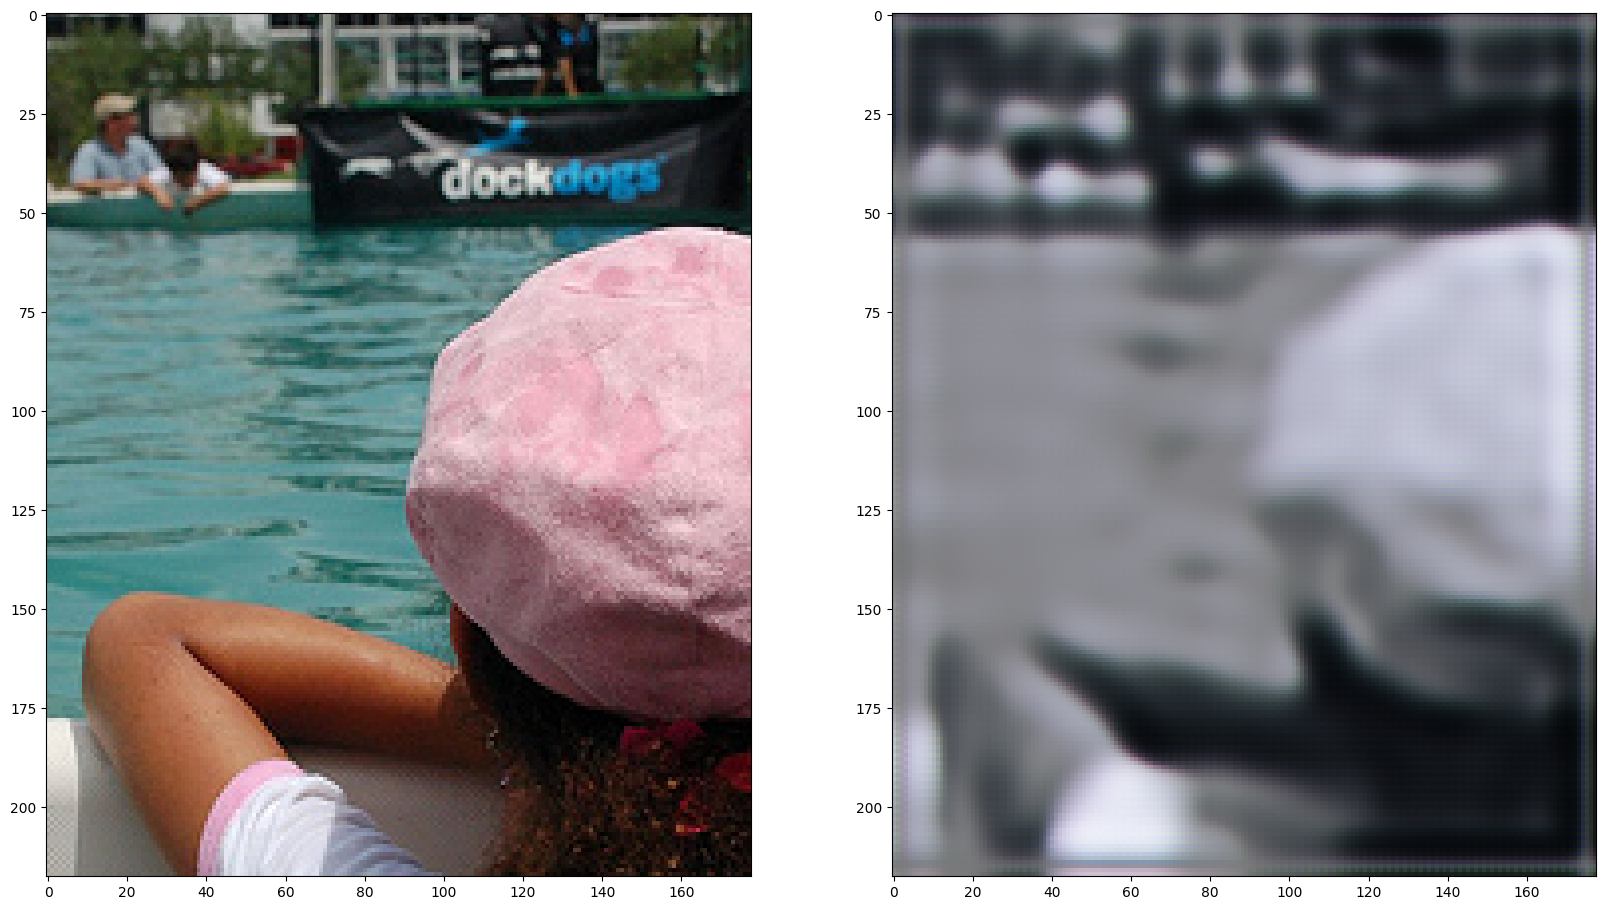

[0/7][550/1272]	Loss_D: 0.5834	Loss_G: 2.8298	Loss_E: 2.7877	D(x): 0.8877	D(G(z)): 0.1250 / 0.1310
[0/7][600/1272]	Loss_D: 1.7284	Loss_G: 1.4076	Loss_E: 1.4001	D(x): 0.7951	D(G(z)): 0.7615 / 0.7283
[0/7][650/1272]	Loss_D: 1.3862	Loss_G: 1.4673	Loss_E: 1.4674	D(x): 0.4990	D(G(z)): 0.4991 / 0.4963
[0/7][700/1272]	Loss_D: 1.3863	Loss_G: 1.4424	Loss_E: 1.4424	D(x): 0.5002	D(G(z)): 0.5002 / 0.5014
[0/7][750/1272]	Loss_D: 1.3862	Loss_G: 1.3352	Loss_E: 1.3352	D(x): 0.5029	D(G(z)): 0.5029 / 0.5045
[0/7][800/1272]	Loss_D: 1.3862	Loss_G: 1.3530	Loss_E: 1.3533	D(x): 0.5056	D(G(z)): 0.5056 / 0.5059
[0/7][850/1272]	Loss_D: 1.3862	Loss_G: 1.3351	Loss_E: 1.3346	D(x): 0.5089	D(G(z)): 0.5093 / 0.5108
[0/7][900/1272]	Loss_D: 1.3862	Loss_G: 1.4304	Loss_E: 1.4307	D(x): 0.5019	D(G(z)): 0.5019 / 0.5029
[0/7][950/1272]	Loss_D: 1.3864	Loss_G: 1.3351	Loss_E: 1.3351	D(x): 0.5041	D(G(z)): 0.5041 / 0.5034
[0/7][1000/1272]	Loss_D: 1.3864	Loss_G: 1.4420	Loss_E: 1.4421	D(x): 0.5060	D(G(z)): 0.5060 / 0.5046


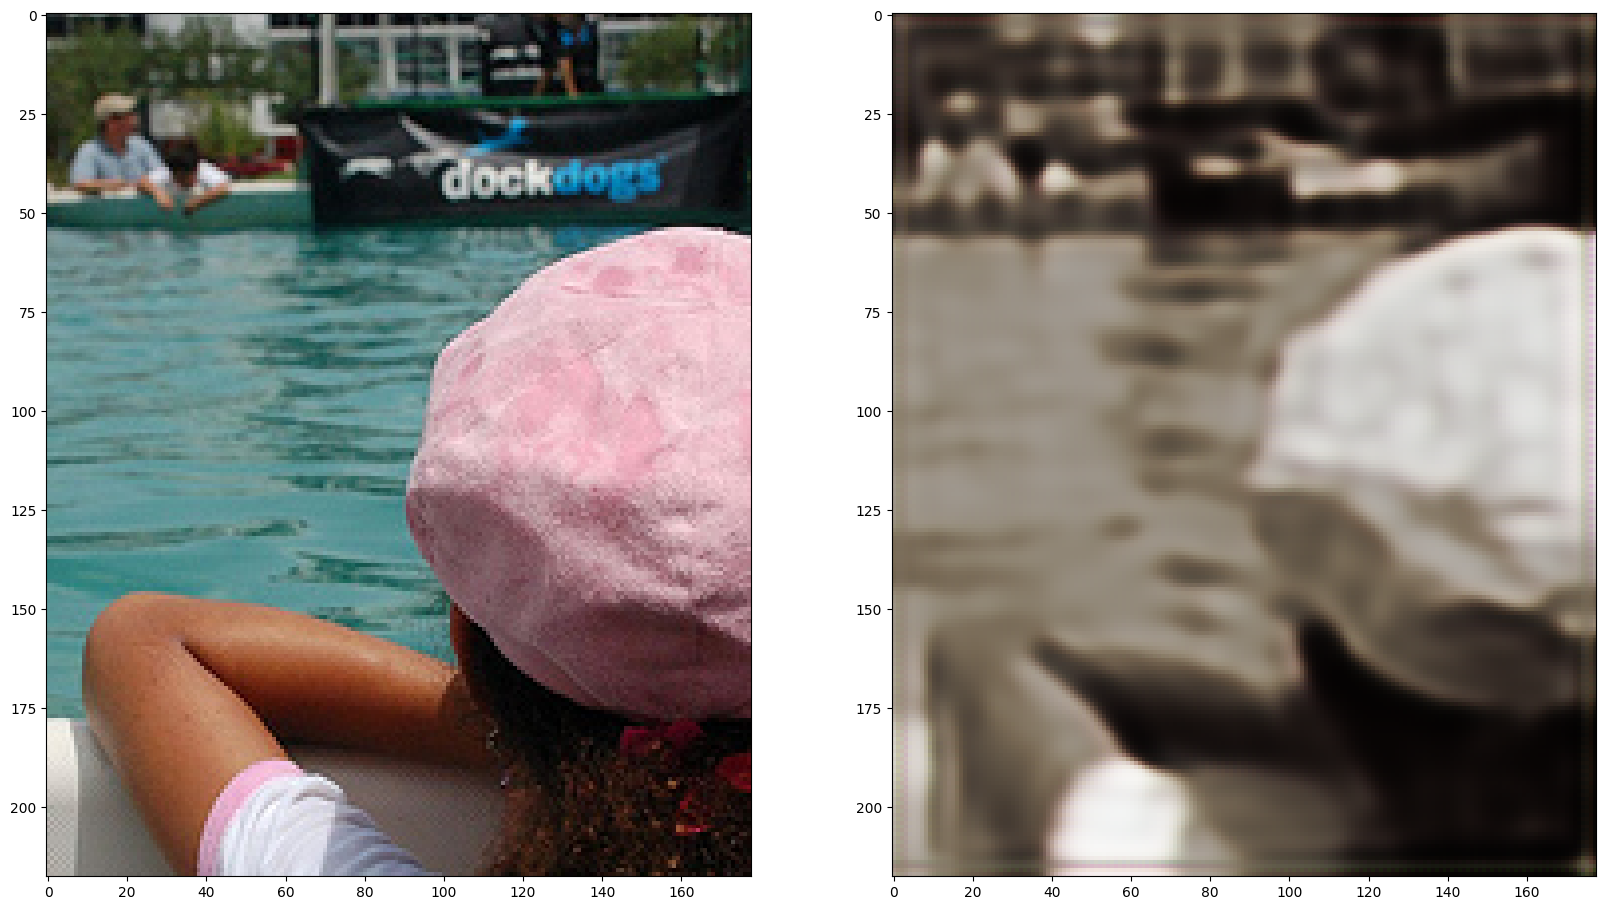

[0/7][1050/1272]	Loss_D: 1.3846	Loss_G: 1.3899	Loss_E: 1.3900	D(x): 0.5036	D(G(z)): 0.5026 / 0.5027
[0/7][1100/1272]	Loss_D: 1.3821	Loss_G: 1.4439	Loss_E: 1.4440	D(x): 0.5043	D(G(z)): 0.5019 / 0.5053
[0/7][1150/1272]	Loss_D: 1.3669	Loss_G: 1.3211	Loss_E: 1.3225	D(x): 0.5102	D(G(z)): 0.4989 / 0.4935
[0/7][1200/1272]	Loss_D: 1.3833	Loss_G: 1.5004	Loss_E: 1.5001	D(x): 0.5326	D(G(z)): 0.5295 / 0.5215
[0/7][1250/1272]	Loss_D: 1.3769	Loss_G: 1.3997	Loss_E: 1.3998	D(x): 0.5073	D(G(z)): 0.5015 / 0.4991
[1/7][0/1272]	Loss_D: 1.3751	Loss_G: 1.4586	Loss_E: 1.4605	D(x): 0.5094	D(G(z)): 0.5025 / 0.4958


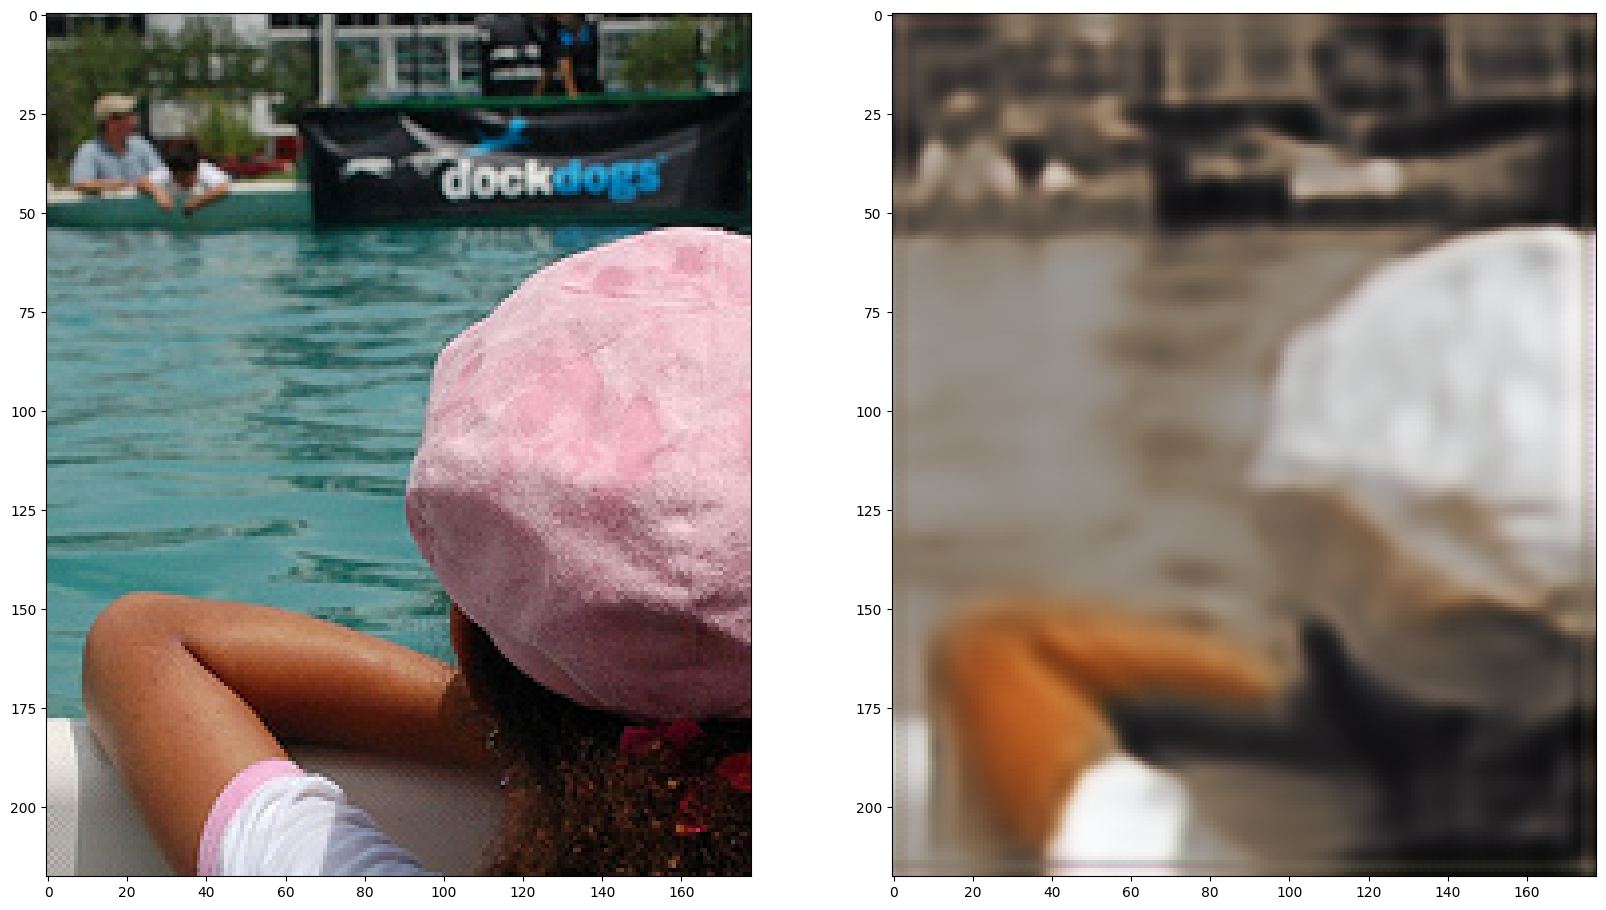

[1/7][50/1272]	Loss_D: 1.3680	Loss_G: 1.3946	Loss_E: 1.3945	D(x): 0.5026	D(G(z)): 0.4909 / 0.4776
[1/7][100/1272]	Loss_D: 1.3728	Loss_G: 1.3046	Loss_E: 1.3040	D(x): 0.5012	D(G(z)): 0.4929 / 0.5025
[1/7][150/1272]	Loss_D: 1.3958	Loss_G: 1.3051	Loss_E: 1.3052	D(x): 0.5040	D(G(z)): 0.5091 / 0.5090
[1/7][200/1272]	Loss_D: 1.3903	Loss_G: 1.2130	Loss_E: 1.2133	D(x): 0.4883	D(G(z)): 0.4898 / 0.4983
[1/7][250/1272]	Loss_D: 1.3865	Loss_G: 1.2939	Loss_E: 1.2940	D(x): 0.5139	D(G(z)): 0.5131 / 0.5082
[1/7][300/1272]	Loss_D: 1.3846	Loss_G: 1.2969	Loss_E: 1.2972	D(x): 0.5003	D(G(z)): 0.4993 / 0.4993
[1/7][350/1272]	Loss_D: 1.3859	Loss_G: 1.2530	Loss_E: 1.2534	D(x): 0.5041	D(G(z)): 0.5038 / 0.5020
[1/7][400/1272]	Loss_D: 1.3867	Loss_G: 1.2584	Loss_E: 1.2585	D(x): 0.5047	D(G(z)): 0.5050 / 0.5042
[1/7][450/1272]	Loss_D: 1.3952	Loss_G: 1.3627	Loss_E: 1.3635	D(x): 0.4947	D(G(z)): 0.4985 / 0.5014
[1/7][500/1272]	Loss_D: 1.3872	Loss_G: 1.1029	Loss_E: 1.1027	D(x): 0.5059	D(G(z)): 0.5066 / 0.5097


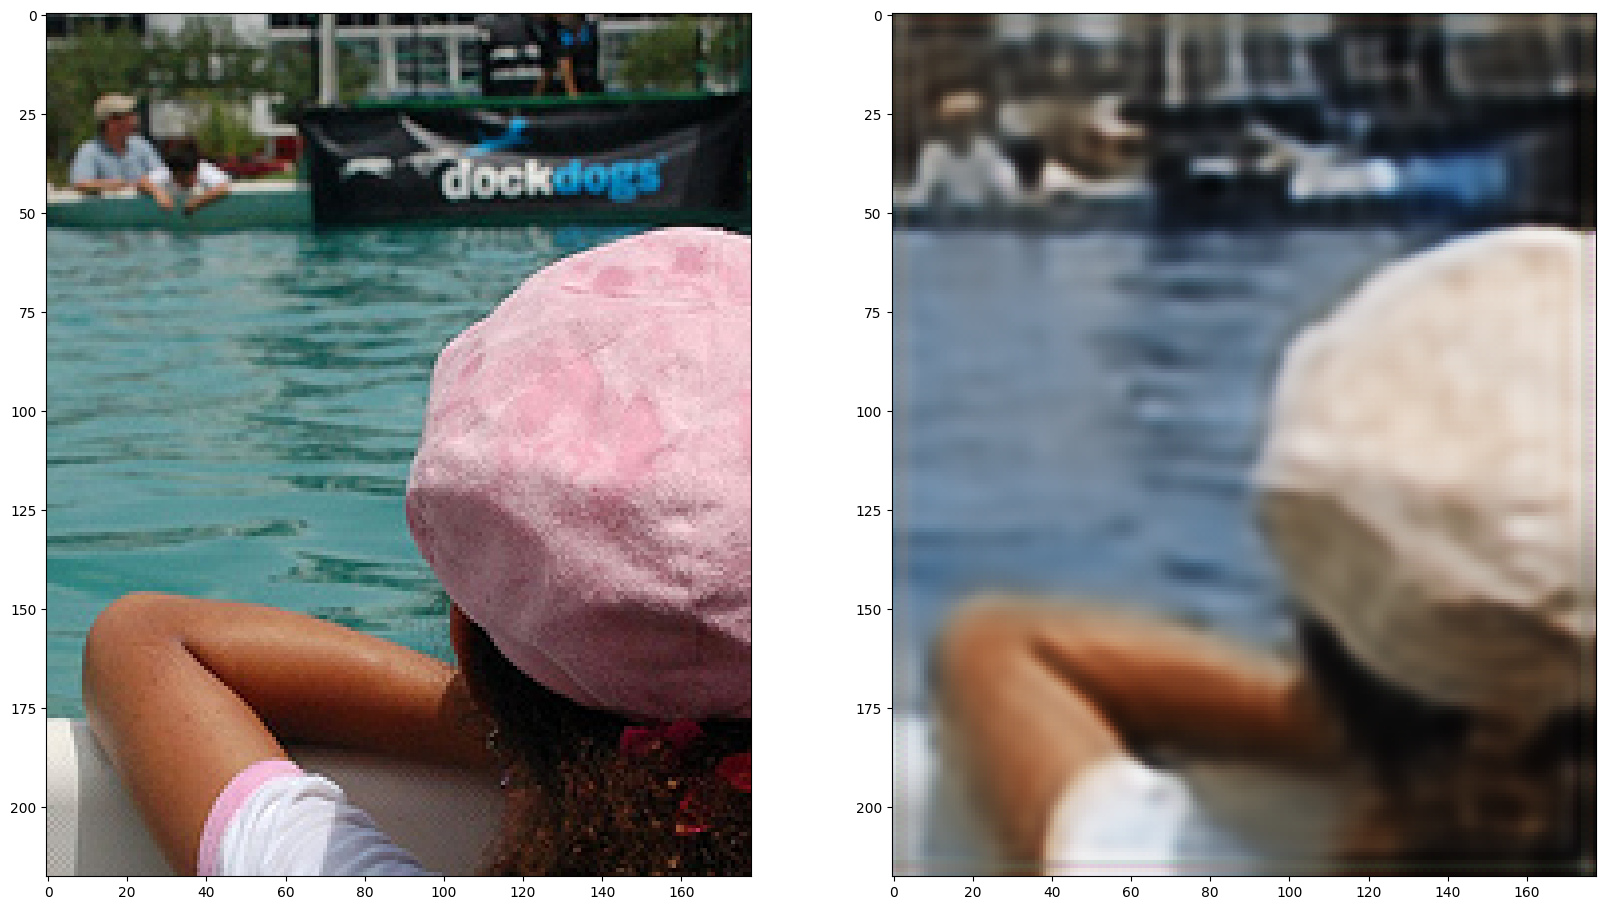

[1/7][550/1272]	Loss_D: 1.3864	Loss_G: 1.2603	Loss_E: 1.2602	D(x): 0.5016	D(G(z)): 0.5016 / 0.5019
[1/7][600/1272]	Loss_D: 1.3874	Loss_G: 1.1544	Loss_E: 1.1544	D(x): 0.5128	D(G(z)): 0.5131 / 0.5109
[1/7][650/1272]	Loss_D: 1.3863	Loss_G: 1.2230	Loss_E: 1.2230	D(x): 0.5080	D(G(z)): 0.5079 / 0.5074
[1/7][700/1272]	Loss_D: 1.3868	Loss_G: 1.2605	Loss_E: 1.2607	D(x): 0.5103	D(G(z)): 0.5101 / 0.5048
[1/7][750/1272]	Loss_D: 1.3863	Loss_G: 1.2456	Loss_E: 1.2456	D(x): 0.5109	D(G(z)): 0.5110 / 0.5091
[1/7][800/1272]	Loss_D: 1.3858	Loss_G: 1.1511	Loss_E: 1.1507	D(x): 0.5109	D(G(z)): 0.5107 / 0.5117
[1/7][850/1272]	Loss_D: 1.3864	Loss_G: 1.2035	Loss_E: 1.2035	D(x): 0.5010	D(G(z)): 0.5010 / 0.5001
[1/7][900/1272]	Loss_D: 1.3861	Loss_G: 1.2271	Loss_E: 1.2272	D(x): 0.5031	D(G(z)): 0.5031 / 0.5049
[1/7][950/1272]	Loss_D: 1.3861	Loss_G: 1.1478	Loss_E: 1.1481	D(x): 0.5049	D(G(z)): 0.5047 / 0.5021
[1/7][1000/1272]	Loss_D: 1.3862	Loss_G: 1.2193	Loss_E: 1.2192	D(x): 0.4976	D(G(z)): 0.4976 / 0.4990


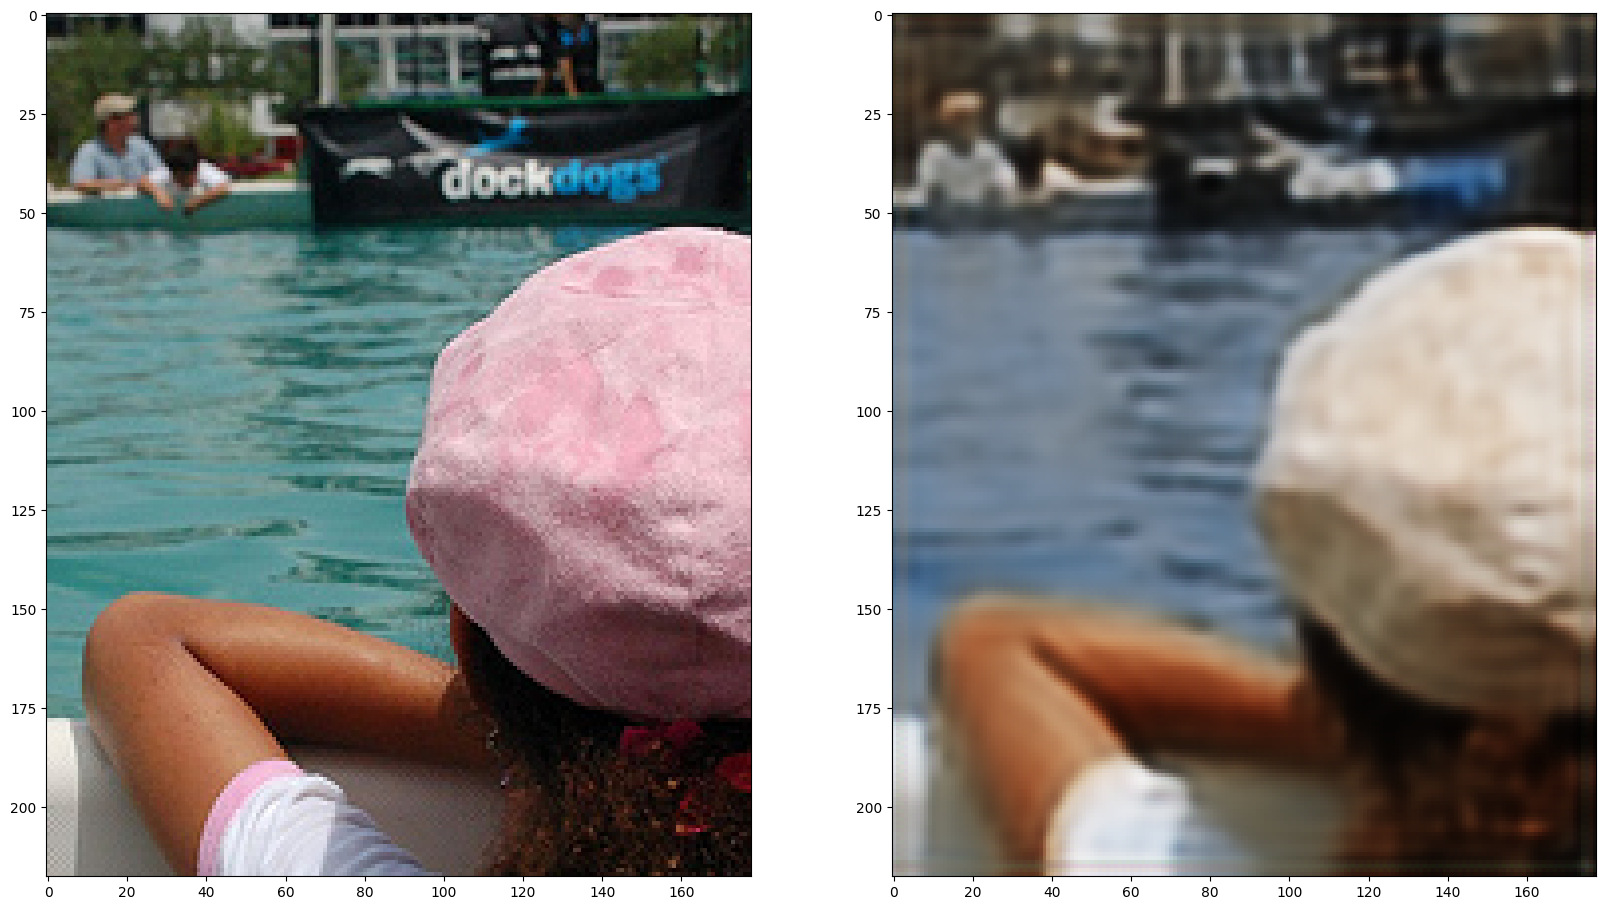

[1/7][1050/1272]	Loss_D: 1.3864	Loss_G: 1.1855	Loss_E: 1.1855	D(x): 0.5063	D(G(z)): 0.5063 / 0.5076
[1/7][1100/1272]	Loss_D: 1.3867	Loss_G: 1.1240	Loss_E: 1.1238	D(x): 0.5070	D(G(z)): 0.5070 / 0.5047
[1/7][1150/1272]	Loss_D: 1.3860	Loss_G: 1.1973	Loss_E: 1.1975	D(x): 0.5051	D(G(z)): 0.5048 / 0.5022
[1/7][1200/1272]	Loss_D: 1.3862	Loss_G: 1.2013	Loss_E: 1.2014	D(x): 0.5009	D(G(z)): 0.5009 / 0.5039
[1/7][1250/1272]	Loss_D: 1.3866	Loss_G: 1.2095	Loss_E: 1.2093	D(x): 0.4982	D(G(z)): 0.4983 / 0.4972
[2/7][0/1272]	Loss_D: 1.3864	Loss_G: 1.1686	Loss_E: 1.1683	D(x): 0.5034	D(G(z)): 0.5035 / 0.5068


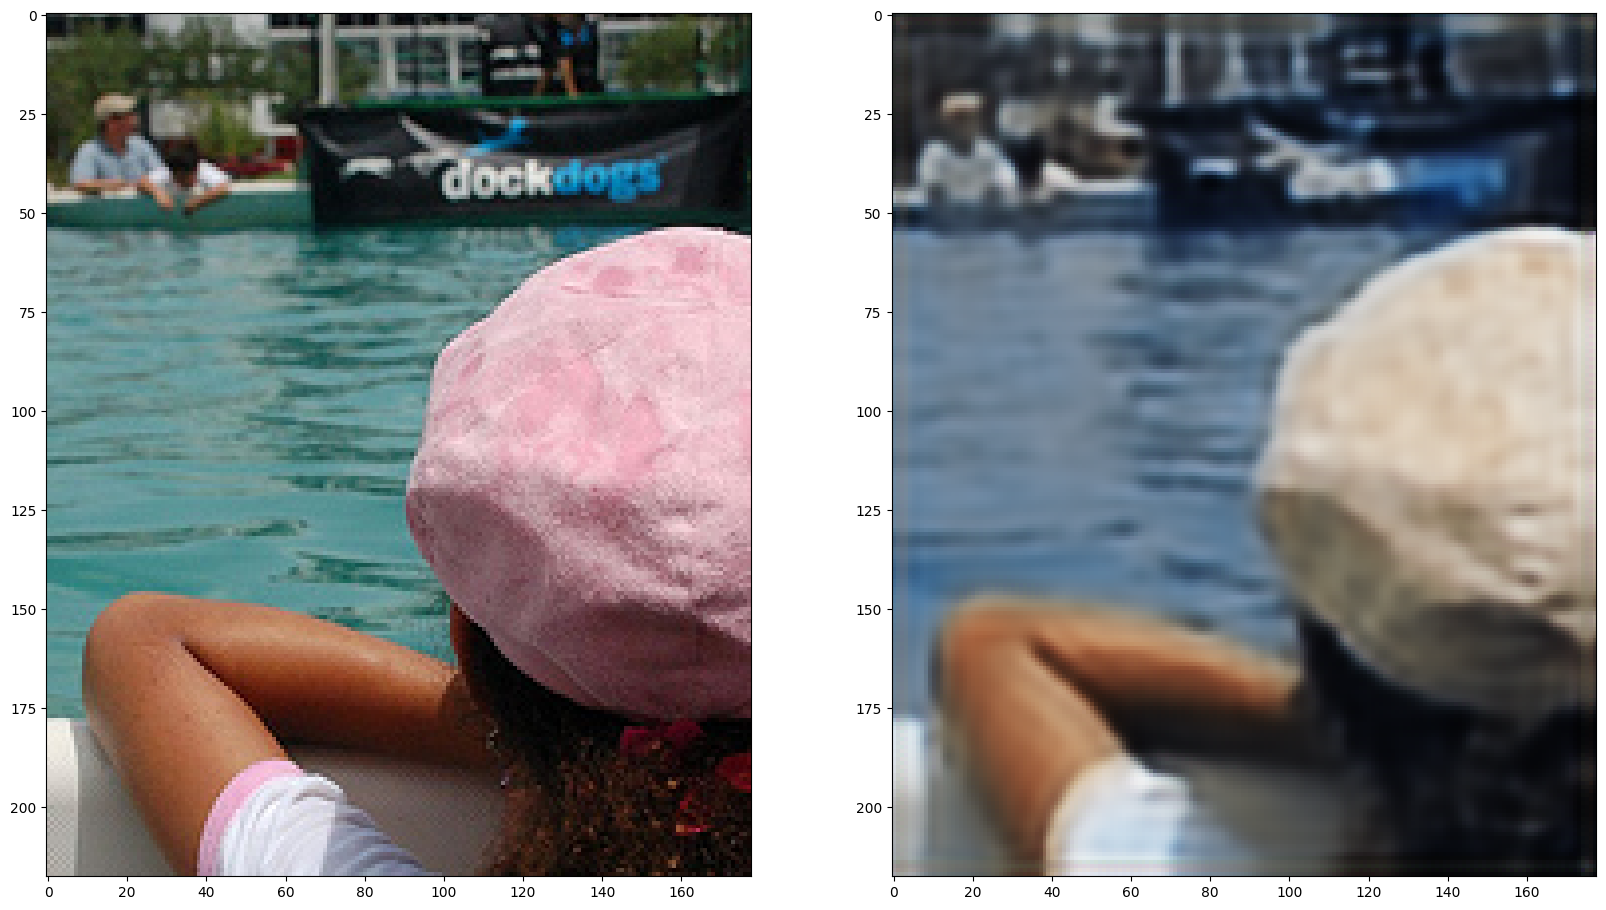

[2/7][50/1272]	Loss_D: 1.3864	Loss_G: 1.2086	Loss_E: 1.2086	D(x): 0.5018	D(G(z)): 0.5018 / 0.5006
[2/7][100/1272]	Loss_D: 1.3860	Loss_G: 1.1816	Loss_E: 1.1819	D(x): 0.5025	D(G(z)): 0.5024 / 0.5032
[2/7][150/1272]	Loss_D: 1.3861	Loss_G: 1.2398	Loss_E: 1.2400	D(x): 0.5044	D(G(z)): 0.5044 / 0.5041
[2/7][200/1272]	Loss_D: 1.3860	Loss_G: 1.1466	Loss_E: 1.1473	D(x): 0.5068	D(G(z)): 0.5068 / 0.5079
[2/7][250/1272]	Loss_D: 1.3865	Loss_G: 1.1126	Loss_E: 1.1127	D(x): 0.5045	D(G(z)): 0.5046 / 0.5039
[2/7][300/1272]	Loss_D: 1.3864	Loss_G: 1.2139	Loss_E: 1.2140	D(x): 0.5057	D(G(z)): 0.5057 / 0.5041
[2/7][350/1272]	Loss_D: 1.3866	Loss_G: 1.1883	Loss_E: 1.1882	D(x): 0.4960	D(G(z)): 0.4959 / 0.4996
[2/7][400/1272]	Loss_D: 1.3856	Loss_G: 1.1437	Loss_E: 1.1441	D(x): 0.5044	D(G(z)): 0.5041 / 0.5041
[2/7][450/1272]	Loss_D: 1.3860	Loss_G: 1.1003	Loss_E: 1.1001	D(x): 0.5066	D(G(z)): 0.5065 / 0.5076
[2/7][500/1272]	Loss_D: 1.3878	Loss_G: 1.1035	Loss_E: 1.1034	D(x): 0.5045	D(G(z)): 0.5055 / 0.5063


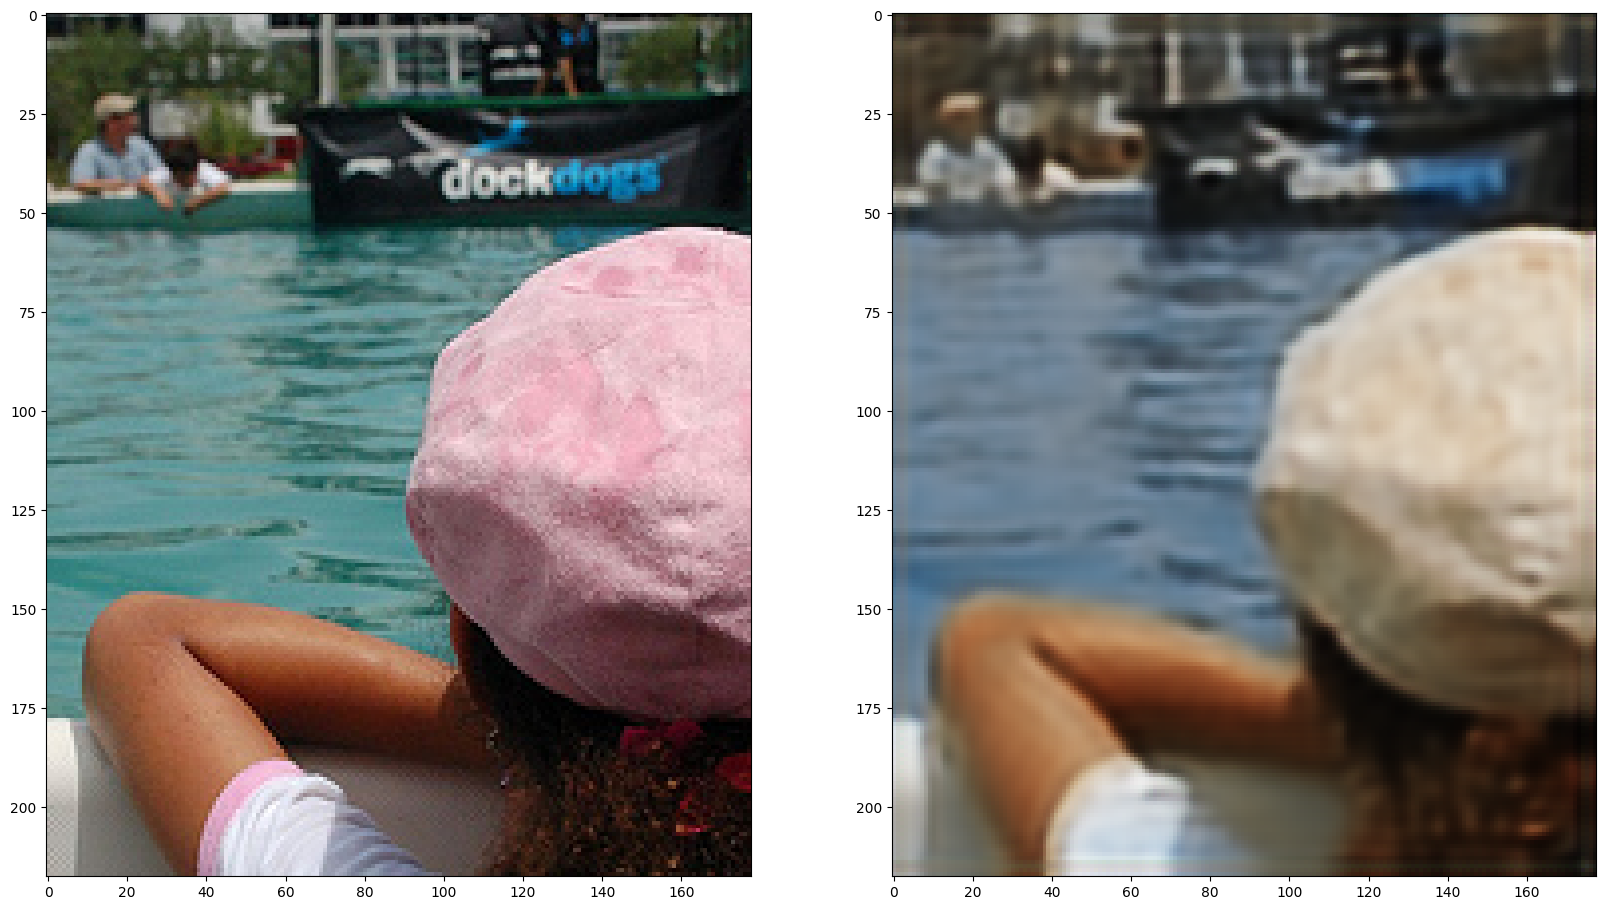

[2/7][550/1272]	Loss_D: 1.3866	Loss_G: 1.0789	Loss_E: 1.0787	D(x): 0.5077	D(G(z)): 0.5078 / 0.5070
[2/7][600/1272]	Loss_D: 1.3908	Loss_G: 1.1308	Loss_E: 1.1308	D(x): 0.4955	D(G(z)): 0.4977 / 0.4985
[2/7][650/1272]	Loss_D: 1.3860	Loss_G: 1.1863	Loss_E: 1.1865	D(x): 0.5011	D(G(z)): 0.5011 / 0.5010
[2/7][700/1272]	Loss_D: 1.3865	Loss_G: 1.1143	Loss_E: 1.1144	D(x): 0.5045	D(G(z)): 0.5045 / 0.5022
[2/7][750/1272]	Loss_D: 1.3863	Loss_G: 1.1671	Loss_E: 1.1671	D(x): 0.5039	D(G(z)): 0.5038 / 0.5024
[2/7][800/1272]	Loss_D: 1.3859	Loss_G: 1.1567	Loss_E: 1.1566	D(x): 0.5064	D(G(z)): 0.5062 / 0.5059
[2/7][850/1272]	Loss_D: 1.3867	Loss_G: 1.0918	Loss_E: 1.0919	D(x): 0.5033	D(G(z)): 0.5034 / 0.5009
[2/7][900/1272]	Loss_D: 1.3860	Loss_G: 1.1543	Loss_E: 1.1542	D(x): 0.5068	D(G(z)): 0.5066 / 0.5066
[2/7][950/1272]	Loss_D: 1.3862	Loss_G: 1.1367	Loss_E: 1.1370	D(x): 0.5083	D(G(z)): 0.5082 / 0.5070
[2/7][1000/1272]	Loss_D: 1.3862	Loss_G: 1.1267	Loss_E: 1.1267	D(x): 0.5020	D(G(z)): 0.5020 / 0.4993


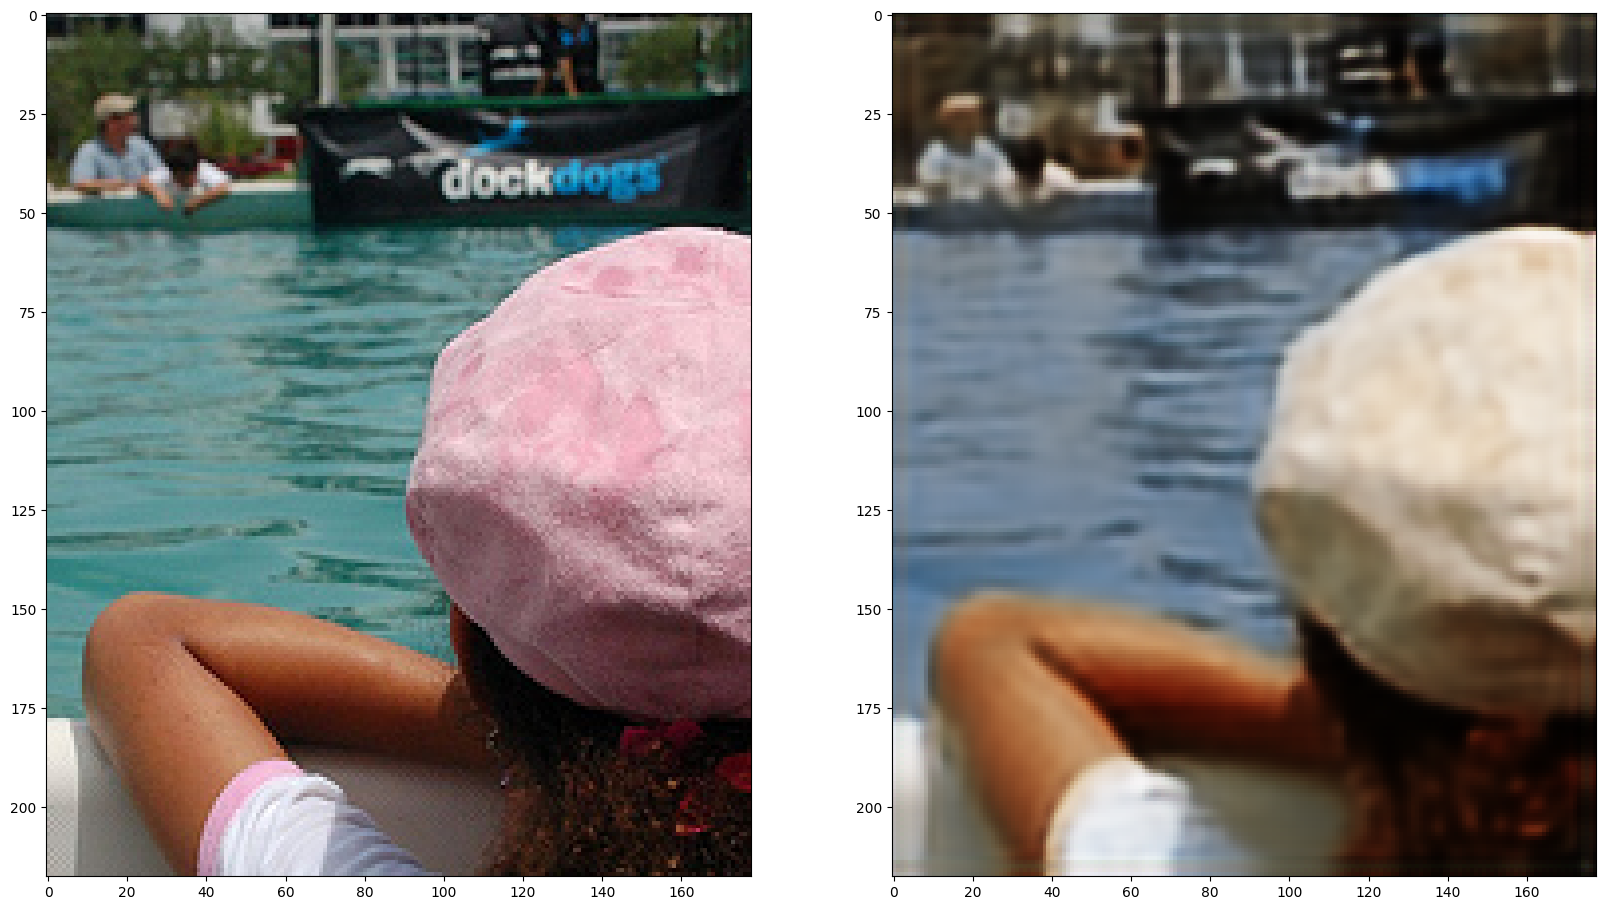

[2/7][1050/1272]	Loss_D: 1.3864	Loss_G: 1.2098	Loss_E: 1.2095	D(x): 0.5014	D(G(z)): 0.5015 / 0.5044
[2/7][1100/1272]	Loss_D: 1.3865	Loss_G: 1.1231	Loss_E: 1.1231	D(x): 0.5038	D(G(z)): 0.5039 / 0.5032
[2/7][1150/1272]	Loss_D: 1.3865	Loss_G: 1.1119	Loss_E: 1.1118	D(x): 0.5045	D(G(z)): 0.5045 / 0.5035
[2/7][1200/1272]	Loss_D: 1.3861	Loss_G: 1.0941	Loss_E: 1.0940	D(x): 0.5006	D(G(z)): 0.5005 / 0.5033
[2/7][1250/1272]	Loss_D: 1.3865	Loss_G: 1.1325	Loss_E: 1.1324	D(x): 0.5030	D(G(z)): 0.5031 / 0.5001
[3/7][0/1272]	Loss_D: 1.3862	Loss_G: 1.1852	Loss_E: 1.1852	D(x): 0.5046	D(G(z)): 0.5045 / 0.5022


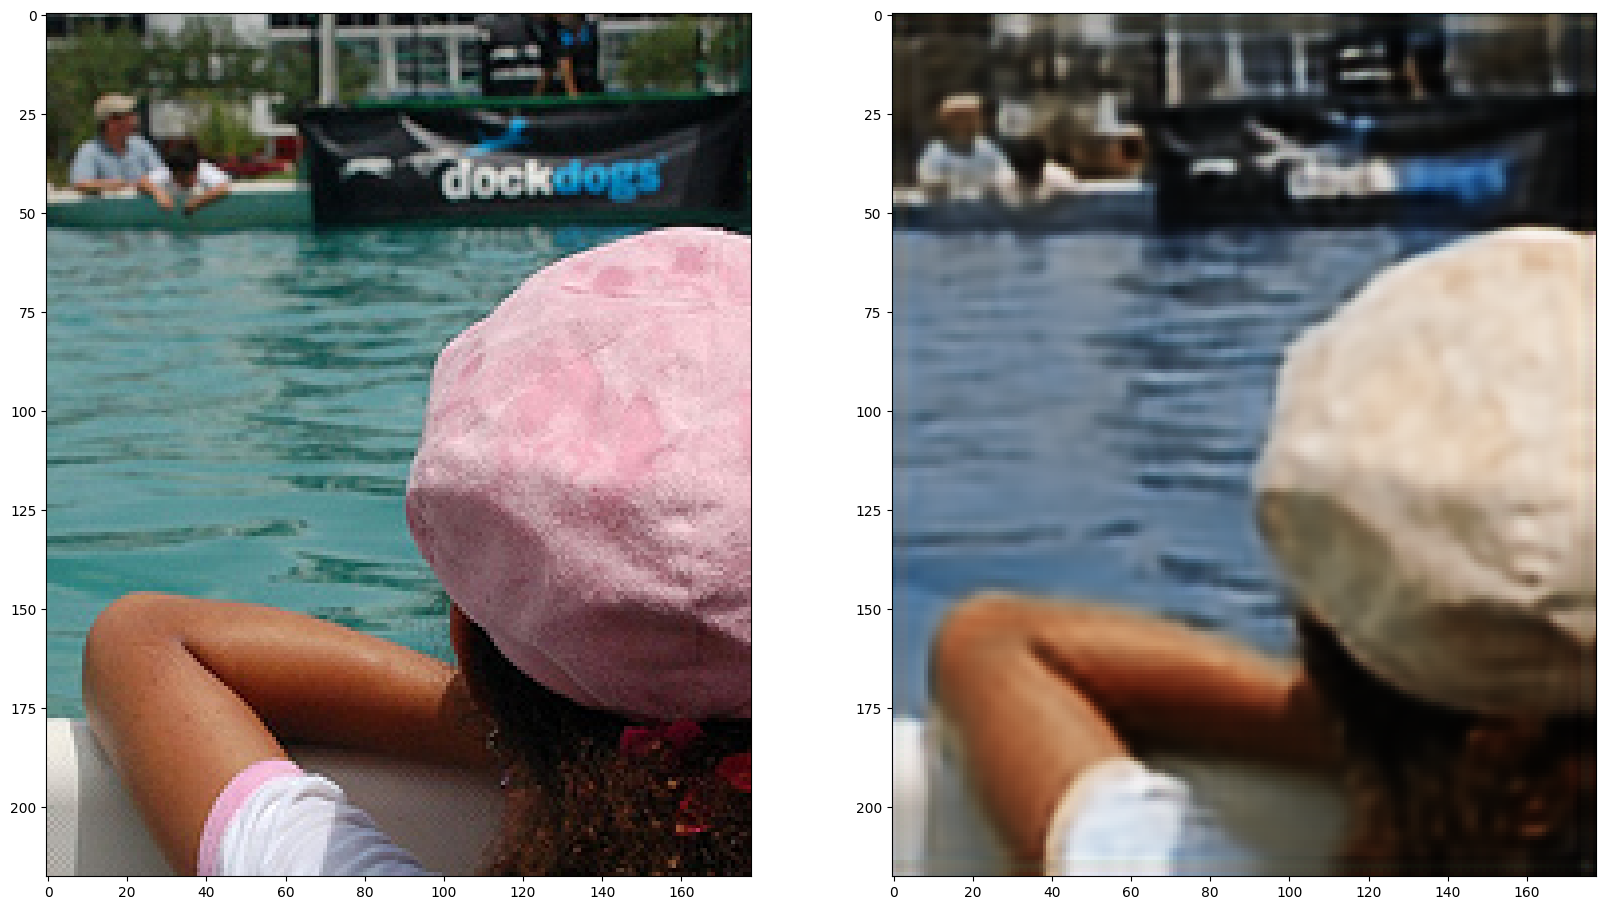

[3/7][50/1272]	Loss_D: 1.3859	Loss_G: 1.1804	Loss_E: 1.1808	D(x): 0.5073	D(G(z)): 0.5072 / 0.5085
[3/7][100/1272]	Loss_D: 1.3863	Loss_G: 1.1413	Loss_E: 1.1415	D(x): 0.5002	D(G(z)): 0.5002 / 0.4996
[3/7][150/1272]	Loss_D: 1.3860	Loss_G: 1.1393	Loss_E: 1.1395	D(x): 0.5044	D(G(z)): 0.5043 / 0.5054
[3/7][200/1272]	Loss_D: 1.3867	Loss_G: 1.1312	Loss_E: 1.1313	D(x): 0.5072	D(G(z)): 0.5072 / 0.5050
[3/7][250/1272]	Loss_D: 1.3863	Loss_G: 1.1123	Loss_E: 1.1124	D(x): 0.5018	D(G(z)): 0.5018 / 0.5018
[3/7][300/1272]	Loss_D: 1.3865	Loss_G: 1.1205	Loss_E: 1.1205	D(x): 0.5000	D(G(z)): 0.5001 / 0.4997
[3/7][350/1272]	Loss_D: 1.3864	Loss_G: 1.1673	Loss_E: 1.1673	D(x): 0.4992	D(G(z)): 0.4992 / 0.5043
[3/7][400/1272]	Loss_D: 1.3858	Loss_G: 1.1253	Loss_E: 1.1253	D(x): 0.5055	D(G(z)): 0.5051 / 0.5028
[3/7][450/1272]	Loss_D: 1.3866	Loss_G: 1.1496	Loss_E: 1.1498	D(x): 0.4985	D(G(z)): 0.4985 / 0.5024
[3/7][500/1272]	Loss_D: 1.3864	Loss_G: 1.1799	Loss_E: 1.1799	D(x): 0.5012	D(G(z)): 0.5012 / 0.4998


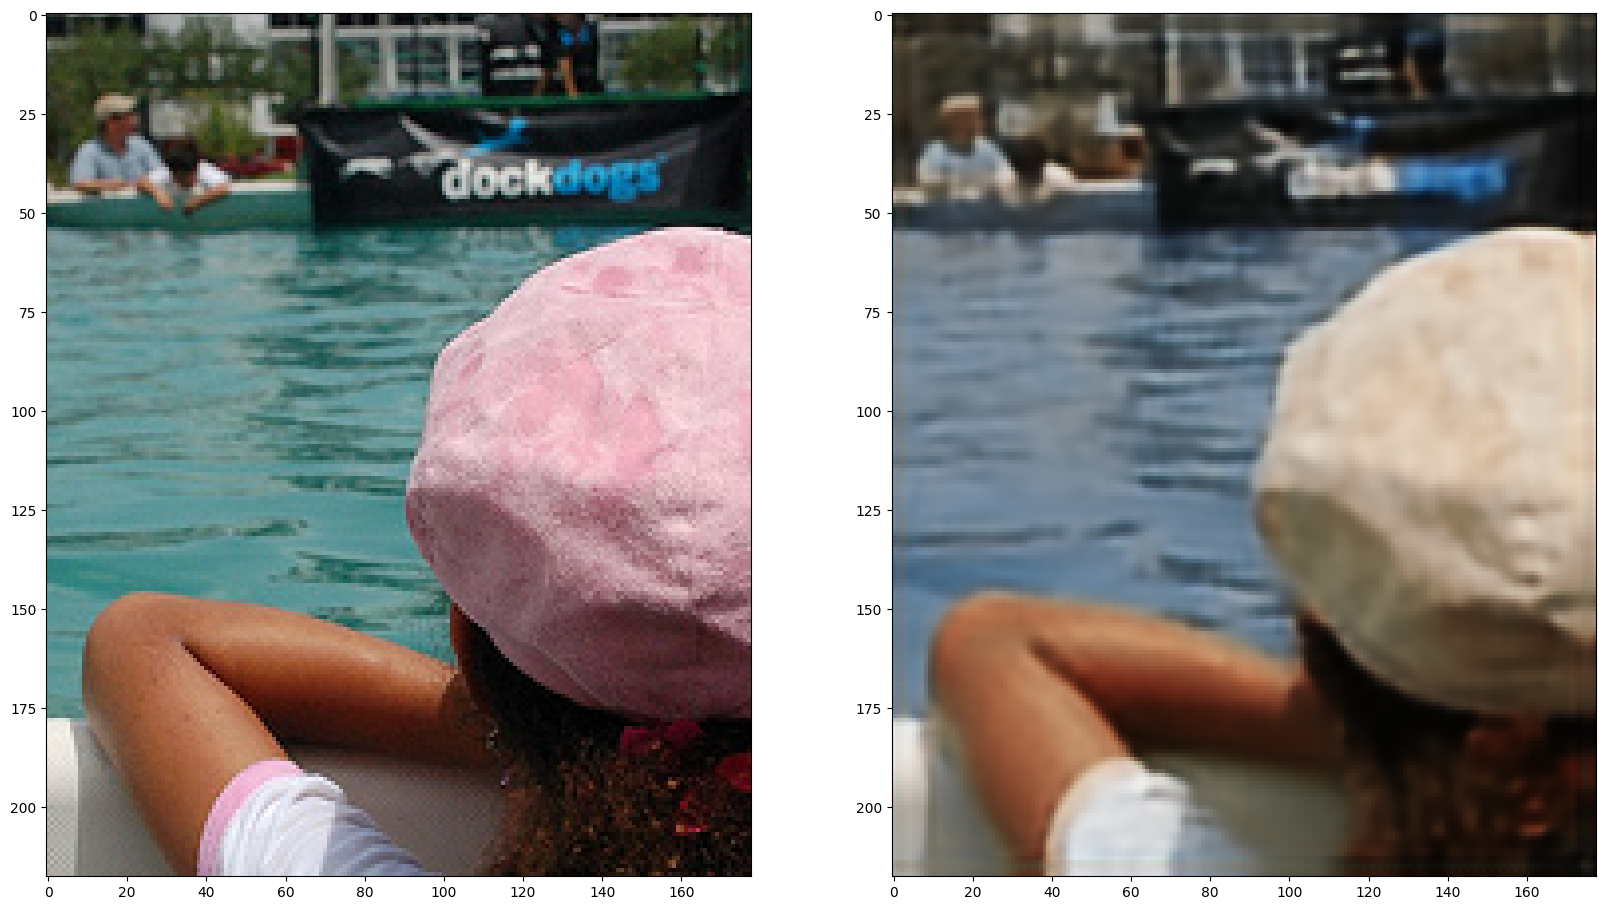

[3/7][550/1272]	Loss_D: 1.3862	Loss_G: 1.0835	Loss_E: 1.0835	D(x): 0.5024	D(G(z)): 0.5023 / 0.5038
[3/7][600/1272]	Loss_D: 1.3861	Loss_G: 1.1607	Loss_E: 1.1605	D(x): 0.5013	D(G(z)): 0.5012 / 0.5002
[3/7][650/1272]	Loss_D: 1.3856	Loss_G: 1.1274	Loss_E: 1.1273	D(x): 0.5042	D(G(z)): 0.5041 / 0.5058
[3/7][700/1272]	Loss_D: 1.3858	Loss_G: 1.1066	Loss_E: 1.1064	D(x): 0.5066	D(G(z)): 0.5065 / 0.5076
[3/7][750/1272]	Loss_D: 1.3863	Loss_G: 1.1614	Loss_E: 1.1615	D(x): 0.5030	D(G(z)): 0.5030 / 0.5024
[3/7][800/1272]	Loss_D: 1.3865	Loss_G: 1.1227	Loss_E: 1.1228	D(x): 0.5012	D(G(z)): 0.5015 / 0.5045
[3/7][850/1272]	Loss_D: 1.3862	Loss_G: 1.1148	Loss_E: 1.1148	D(x): 0.5033	D(G(z)): 0.5032 / 0.5024
[3/7][900/1272]	Loss_D: 1.3877	Loss_G: 1.0923	Loss_E: 1.0922	D(x): 0.5003	D(G(z)): 0.5011 / 0.5029
[3/7][950/1272]	Loss_D: 1.3860	Loss_G: 1.1643	Loss_E: 1.1643	D(x): 0.4986	D(G(z)): 0.4984 / 0.4983
[3/7][1000/1272]	Loss_D: 1.3858	Loss_G: 1.1205	Loss_E: 1.1202	D(x): 0.5054	D(G(z)): 0.5053 / 0.5067


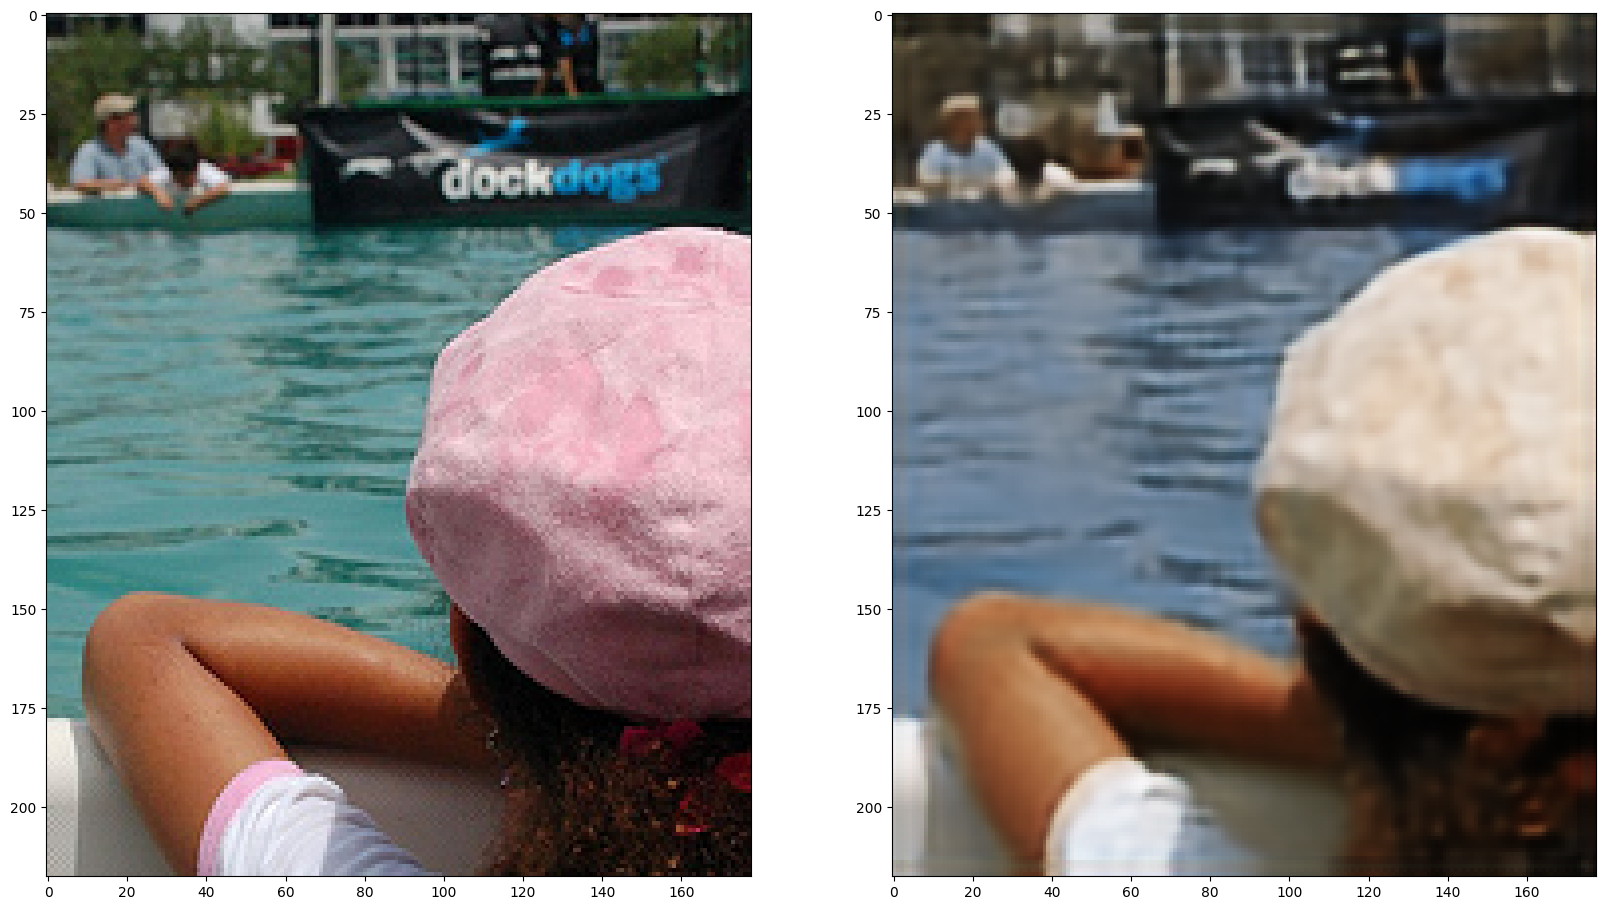

[3/7][1050/1272]	Loss_D: 1.3863	Loss_G: 1.0671	Loss_E: 1.0671	D(x): 0.4992	D(G(z)): 0.4991 / 0.5013
[3/7][1100/1272]	Loss_D: 1.3865	Loss_G: 1.0890	Loss_E: 1.0890	D(x): 0.5055	D(G(z)): 0.5056 / 0.5068
[3/7][1150/1272]	Loss_D: 1.3862	Loss_G: 1.1370	Loss_E: 1.1369	D(x): 0.5005	D(G(z)): 0.5005 / 0.4989
[3/7][1200/1272]	Loss_D: 1.3858	Loss_G: 1.0695	Loss_E: 1.0693	D(x): 0.5079	D(G(z)): 0.5078 / 0.5085
[3/7][1250/1272]	Loss_D: 1.3859	Loss_G: 1.0203	Loss_E: 1.0202	D(x): 0.5023	D(G(z)): 0.5021 / 0.5010
[4/7][0/1272]	Loss_D: 1.3861	Loss_G: 1.1931	Loss_E: 1.1933	D(x): 0.5033	D(G(z)): 0.5032 / 0.5017


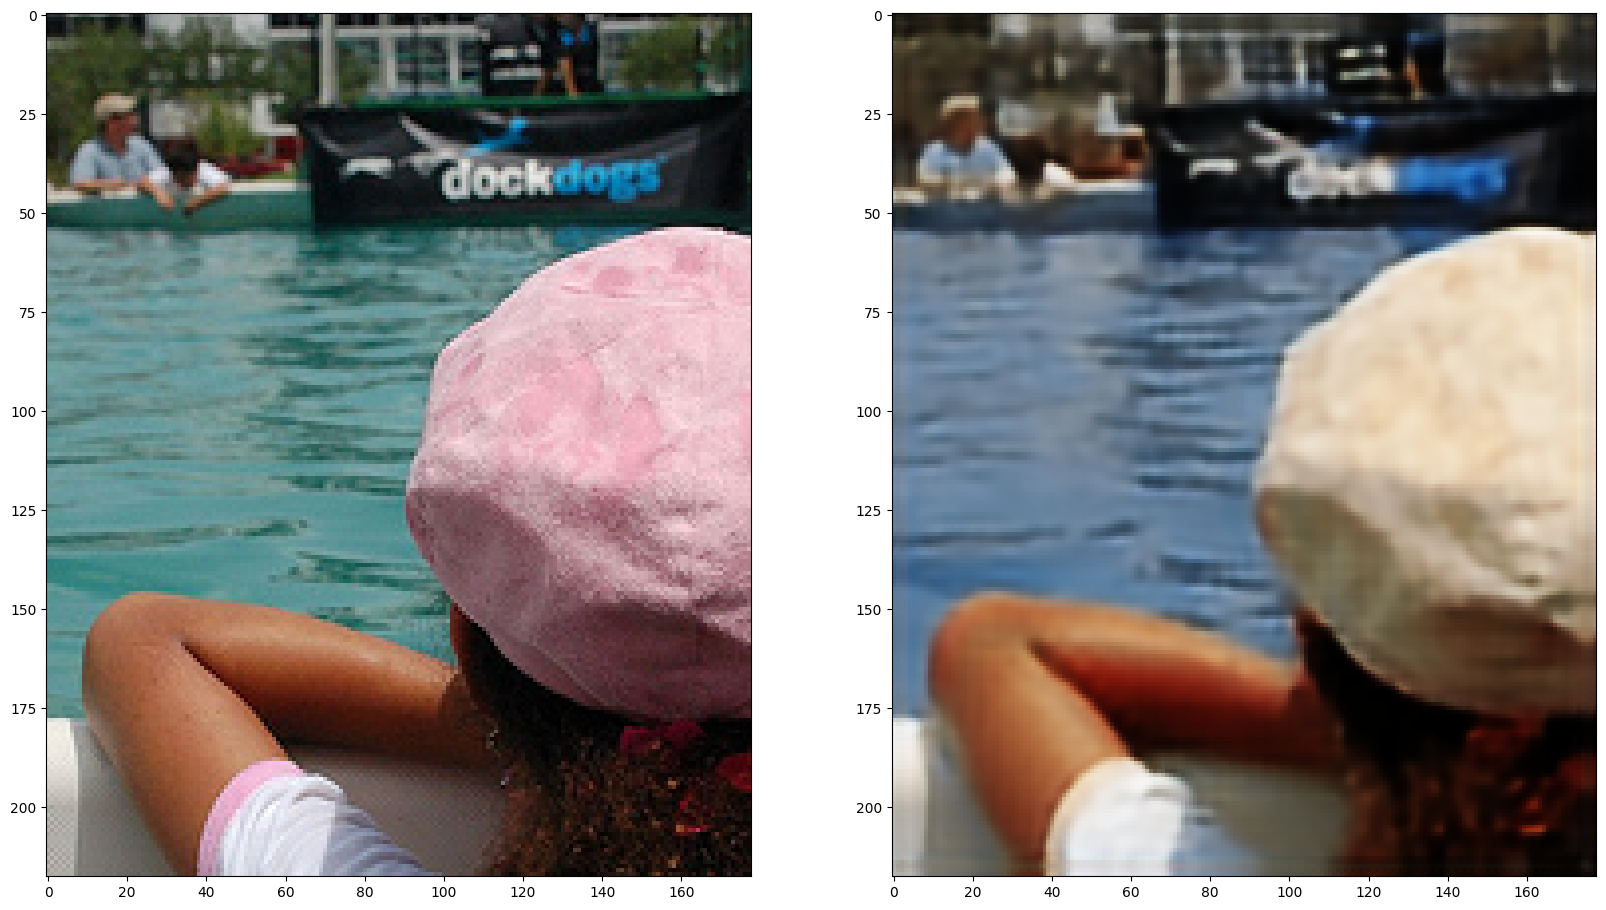

[4/7][50/1272]	Loss_D: 1.3861	Loss_G: 1.0626	Loss_E: 1.0626	D(x): 0.5045	D(G(z)): 0.5045 / 0.5078
[4/7][100/1272]	Loss_D: 1.3860	Loss_G: 1.0839	Loss_E: 1.0839	D(x): 0.5041	D(G(z)): 0.5042 / 0.5070
[4/7][150/1272]	Loss_D: 1.3864	Loss_G: 1.0339	Loss_E: 1.0340	D(x): 0.5056	D(G(z)): 0.5055 / 0.5042
[4/7][200/1272]	Loss_D: 1.3862	Loss_G: 1.0967	Loss_E: 1.0965	D(x): 0.5032	D(G(z)): 0.5031 / 0.5042
[4/7][250/1272]	Loss_D: 1.3863	Loss_G: 1.1116	Loss_E: 1.1118	D(x): 0.5042	D(G(z)): 0.5043 / 0.5030
[4/7][300/1272]	Loss_D: 1.3861	Loss_G: 1.0673	Loss_E: 1.0674	D(x): 0.5057	D(G(z)): 0.5057 / 0.5080
[4/7][350/1272]	Loss_D: 1.3863	Loss_G: 1.0871	Loss_E: 1.0872	D(x): 0.5021	D(G(z)): 0.5022 / 0.5033
[4/7][400/1272]	Loss_D: 1.3861	Loss_G: 1.0174	Loss_E: 1.0172	D(x): 0.5023	D(G(z)): 0.5023 / 0.5030
[4/7][450/1272]	Loss_D: 1.3860	Loss_G: 1.0949	Loss_E: 1.0953	D(x): 0.5069	D(G(z)): 0.5067 / 0.5082
[4/7][500/1272]	Loss_D: 1.3862	Loss_G: 1.0741	Loss_E: 1.0738	D(x): 0.5090	D(G(z)): 0.5087 / 0.5017


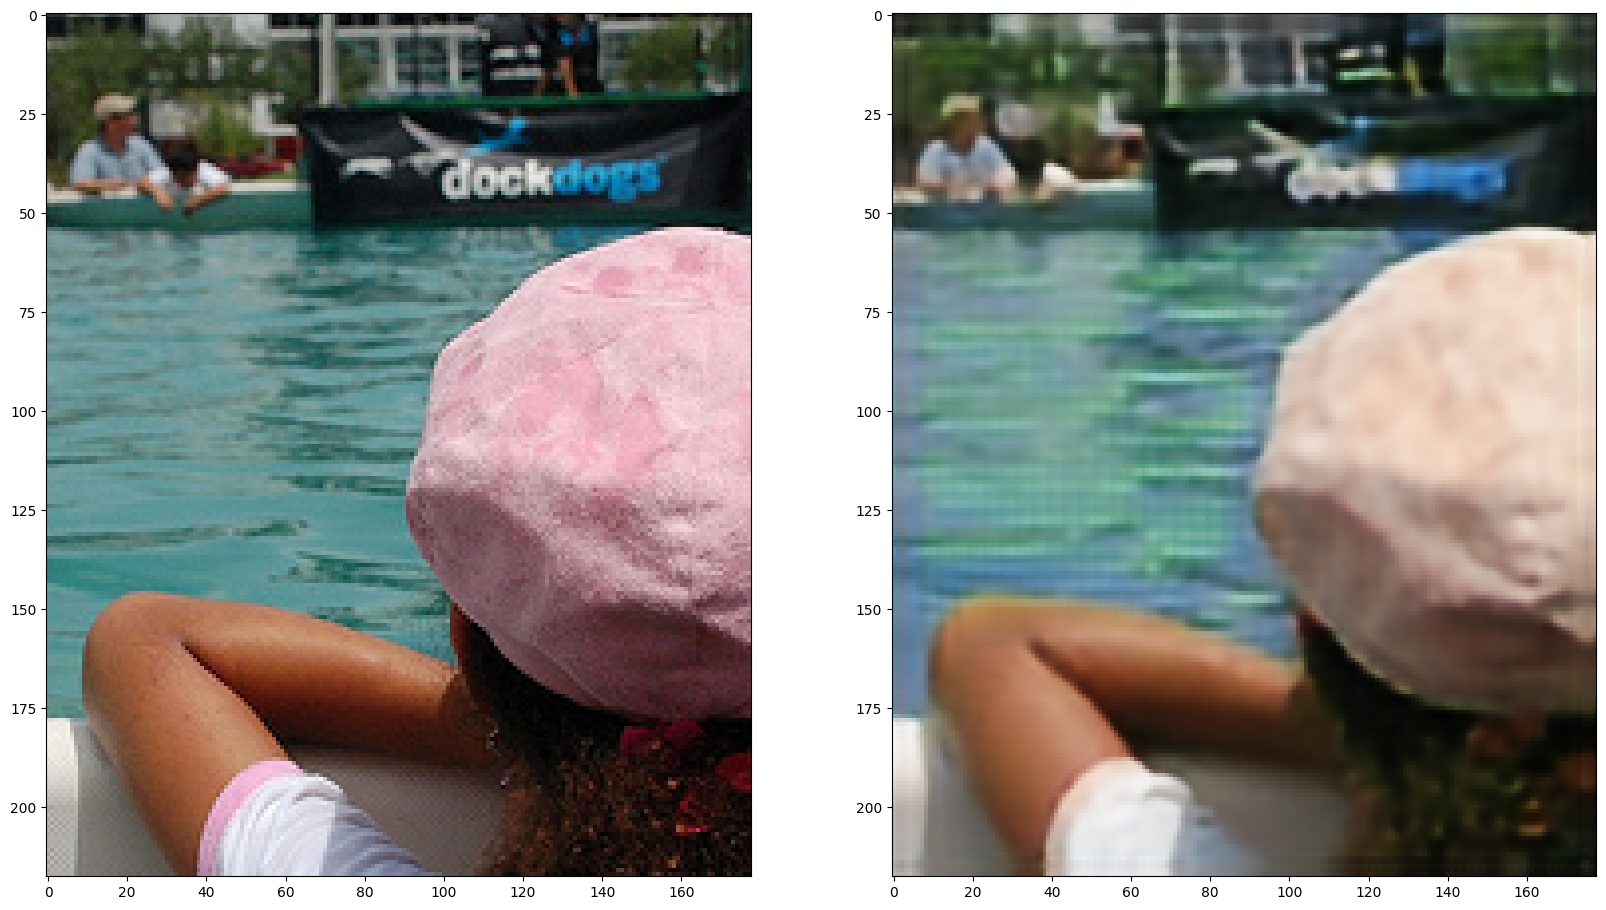

[4/7][550/1272]	Loss_D: 1.3845	Loss_G: 1.0870	Loss_E: 1.0871	D(x): 0.5142	D(G(z)): 0.5137 / 0.5063
[4/7][600/1272]	Loss_D: 1.3696	Loss_G: 0.9864	Loss_E: 0.9856	D(x): 0.4800	D(G(z)): 0.4649 / 0.5702
[4/7][650/1272]	Loss_D: 1.3875	Loss_G: 1.2080	Loss_E: 1.2078	D(x): 0.5493	D(G(z)): 0.5390 / 0.4976
[4/7][700/1272]	Loss_D: 1.3350	Loss_G: 1.2250	Loss_E: 1.2280	D(x): 0.5671	D(G(z)): 0.5290 / 0.4189
[4/7][750/1272]	Loss_D: 1.3599	Loss_G: 1.1367	Loss_E: 1.1354	D(x): 0.5012	D(G(z)): 0.4828 / 0.4823
[4/7][800/1272]	Loss_D: 1.3900	Loss_G: 1.2936	Loss_E: 1.2890	D(x): 0.4693	D(G(z)): 0.4604 / 0.4539
[4/7][850/1272]	Loss_D: 1.3631	Loss_G: 1.1261	Loss_E: 1.1231	D(x): 0.5214	D(G(z)): 0.5022 / 0.4852
[4/7][900/1272]	Loss_D: 1.3851	Loss_G: 1.1893	Loss_E: 1.1888	D(x): 0.5417	D(G(z)): 0.5353 / 0.5126
[4/7][950/1272]	Loss_D: 1.3874	Loss_G: 1.1073	Loss_E: 1.1067	D(x): 0.4672	D(G(z)): 0.4636 / 0.4673
[4/7][1000/1272]	Loss_D: 1.3638	Loss_G: 1.1302	Loss_E: 1.1303	D(x): 0.4881	D(G(z)): 0.4743 / 0.4811


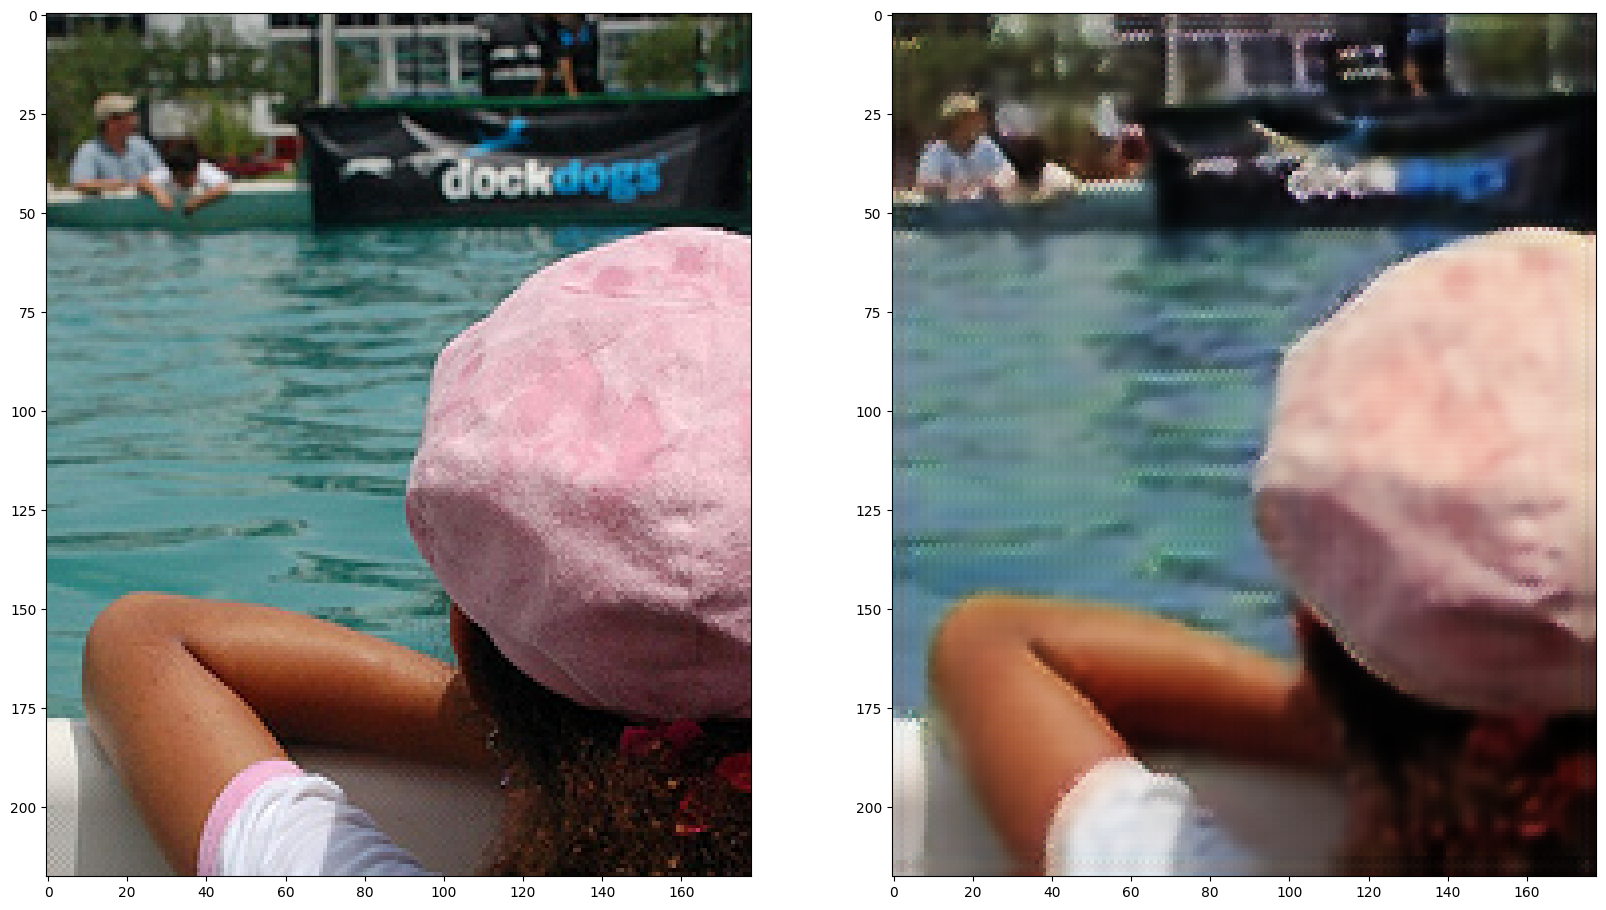

[4/7][1050/1272]	Loss_D: 1.3814	Loss_G: 1.1450	Loss_E: 1.1434	D(x): 0.4817	D(G(z)): 0.4762 / 0.4881
[4/7][1100/1272]	Loss_D: 1.3627	Loss_G: 1.1385	Loss_E: 1.1386	D(x): 0.4839	D(G(z)): 0.4668 / 0.4807
[4/7][1150/1272]	Loss_D: 1.3302	Loss_G: 1.1614	Loss_E: 1.1609	D(x): 0.5256	D(G(z)): 0.4866 / 0.4780
[4/7][1200/1272]	Loss_D: 1.3480	Loss_G: 1.0589	Loss_E: 1.0599	D(x): 0.5071	D(G(z)): 0.4784 / 0.5195
[4/7][1250/1272]	Loss_D: 1.3765	Loss_G: 1.1600	Loss_E: 1.1602	D(x): 0.5268	D(G(z)): 0.5101 / 0.4818
[5/7][0/1272]	Loss_D: 1.3780	Loss_G: 1.1901	Loss_E: 1.1891	D(x): 0.4858	D(G(z)): 0.4775 / 0.4758


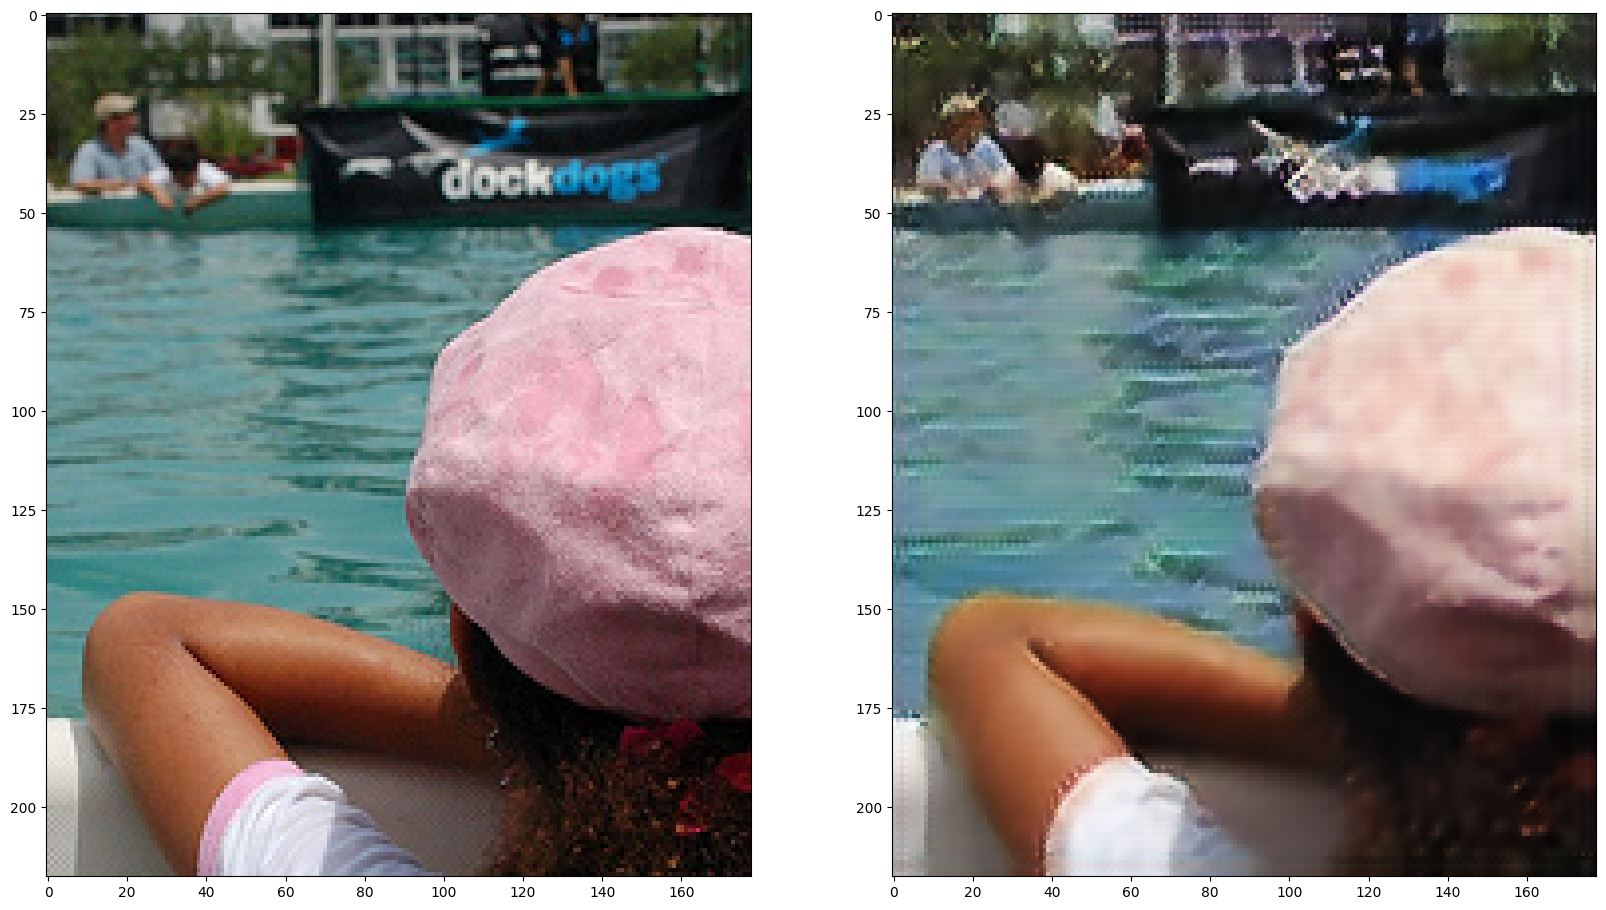

[5/7][50/1272]	Loss_D: 1.3715	Loss_G: 1.2038	Loss_E: 1.2044	D(x): 0.5057	D(G(z)): 0.4906 / 0.4839
[5/7][100/1272]	Loss_D: 1.3600	Loss_G: 1.1671	Loss_E: 1.1672	D(x): 0.5269	D(G(z)): 0.5028 / 0.4945
[5/7][150/1272]	Loss_D: 1.3835	Loss_G: 1.1141	Loss_E: 1.1141	D(x): 0.4828	D(G(z)): 0.4786 / 0.4840
[5/7][200/1272]	Loss_D: 1.3930	Loss_G: 1.1908	Loss_E: 1.1929	D(x): 0.4959	D(G(z)): 0.4920 / 0.4859
[5/7][250/1272]	Loss_D: 1.3764	Loss_G: 1.1054	Loss_E: 1.1052	D(x): 0.4822	D(G(z)): 0.4695 / 0.4906
[5/7][300/1272]	Loss_D: 1.3548	Loss_G: 1.0482	Loss_E: 1.0492	D(x): 0.4984	D(G(z)): 0.4767 / 0.4947
[5/7][350/1272]	Loss_D: 1.4017	Loss_G: 1.1607	Loss_E: 1.1597	D(x): 0.5210	D(G(z)): 0.5232 / 0.5131
[5/7][400/1272]	Loss_D: 1.3536	Loss_G: 1.1435	Loss_E: 1.1421	D(x): 0.5112	D(G(z)): 0.4885 / 0.4751
[5/7][450/1272]	Loss_D: 1.3971	Loss_G: 1.1556	Loss_E: 1.1544	D(x): 0.4897	D(G(z)): 0.4926 / 0.4757
[5/7][500/1272]	Loss_D: 1.3772	Loss_G: 1.1417	Loss_E: 1.1409	D(x): 0.4894	D(G(z)): 0.4810 / 0.4803


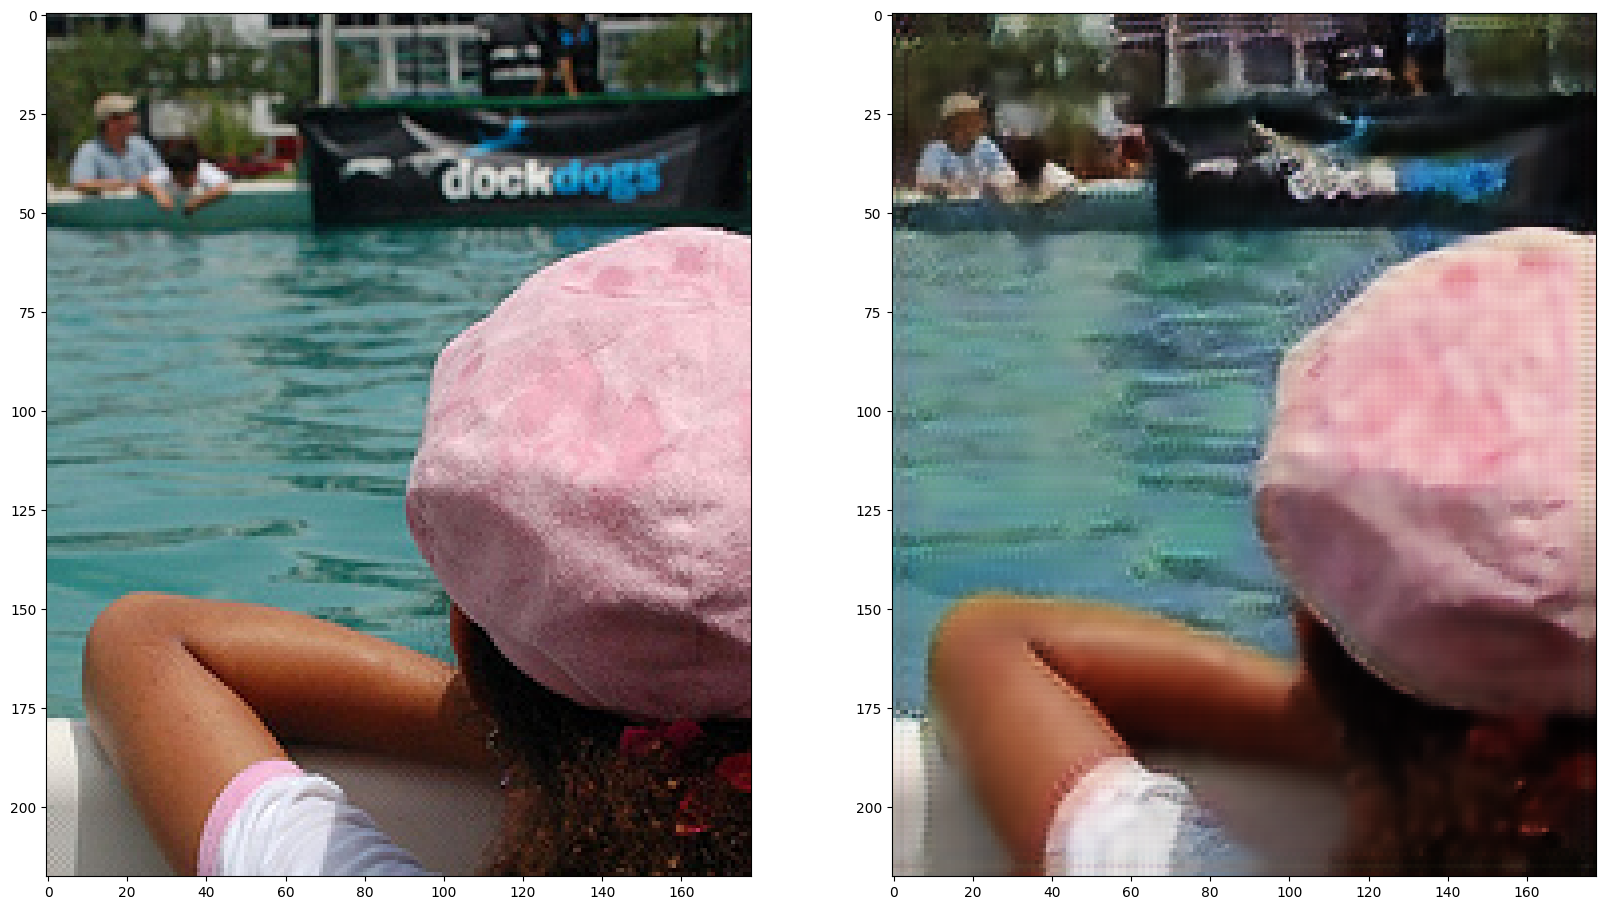

[5/7][550/1272]	Loss_D: 1.3657	Loss_G: 1.1214	Loss_E: 1.1205	D(x): 0.5027	D(G(z)): 0.4866 / 0.4790
[5/7][600/1272]	Loss_D: 1.3309	Loss_G: 1.1669	Loss_E: 1.1674	D(x): 0.5303	D(G(z)): 0.4922 / 0.5062
[5/7][650/1272]	Loss_D: 1.3433	Loss_G: 1.0896	Loss_E: 1.0884	D(x): 0.5154	D(G(z)): 0.4879 / 0.5072
[5/7][700/1272]	Loss_D: 1.3672	Loss_G: 1.1123	Loss_E: 1.1127	D(x): 0.5344	D(G(z)): 0.5144 / 0.5044
[5/7][750/1272]	Loss_D: 1.4129	Loss_G: 1.1526	Loss_E: 1.1548	D(x): 0.5709	D(G(z)): 0.5608 / 0.5461
[5/7][800/1272]	Loss_D: 1.3383	Loss_G: 1.2139	Loss_E: 1.2130	D(x): 0.5228	D(G(z)): 0.4903 / 0.4815
[5/7][850/1272]	Loss_D: 1.3942	Loss_G: 1.1340	Loss_E: 1.1337	D(x): 0.5061	D(G(z)): 0.5043 / 0.4970
[5/7][900/1272]	Loss_D: 1.3948	Loss_G: 1.1660	Loss_E: 1.1626	D(x): 0.5189	D(G(z)): 0.5170 / 0.5042
[5/7][950/1272]	Loss_D: 1.4274	Loss_G: 1.1581	Loss_E: 1.1618	D(x): 0.5229	D(G(z)): 0.5332 / 0.5100
[5/7][1000/1272]	Loss_D: 1.3920	Loss_G: 1.1526	Loss_E: 1.1505	D(x): 0.5027	D(G(z)): 0.4979 / 0.4943


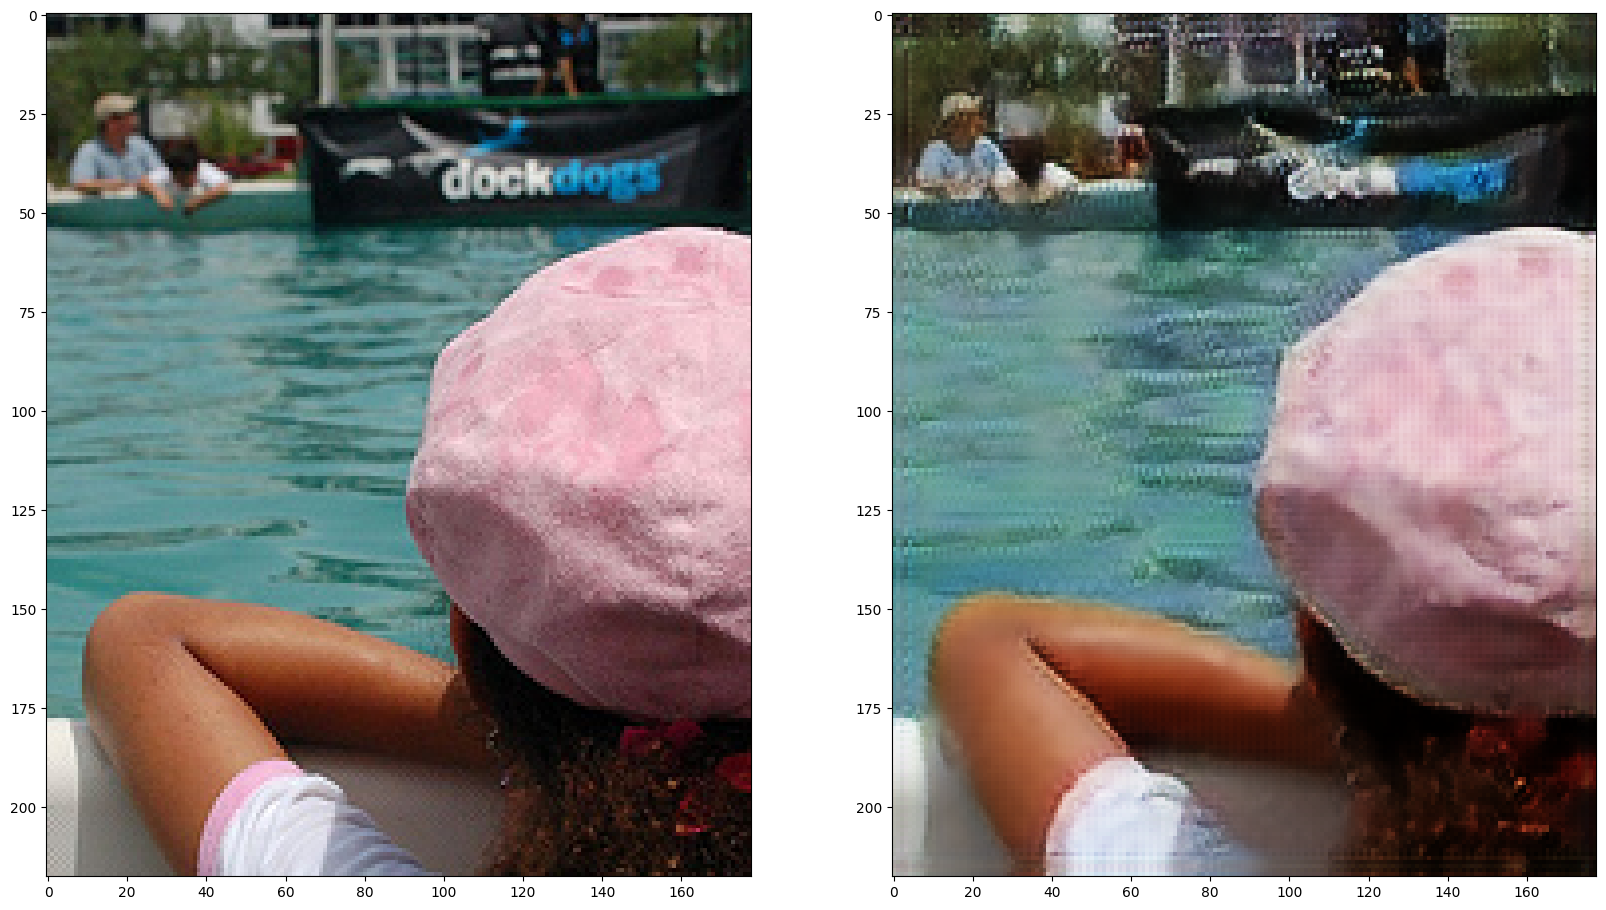

[5/7][1050/1272]	Loss_D: 1.3796	Loss_G: 1.1234	Loss_E: 1.1259	D(x): 0.4946	D(G(z)): 0.4868 / 0.4871
[5/7][1100/1272]	Loss_D: 1.3550	Loss_G: 1.0229	Loss_E: 1.0207	D(x): 0.5036	D(G(z)): 0.4835 / 0.5063
[5/7][1150/1272]	Loss_D: 1.3718	Loss_G: 1.1249	Loss_E: 1.1257	D(x): 0.5365	D(G(z)): 0.5221 / 0.5252
[5/7][1200/1272]	Loss_D: 1.3641	Loss_G: 1.0515	Loss_E: 1.0498	D(x): 0.5306	D(G(z)): 0.5143 / 0.4996
[5/7][1250/1272]	Loss_D: 1.3608	Loss_G: 1.1366	Loss_E: 1.1358	D(x): 0.5371	D(G(z)): 0.5187 / 0.5160
[6/7][0/1272]	Loss_D: 1.4213	Loss_G: 1.1955	Loss_E: 1.1949	D(x): 0.5128	D(G(z)): 0.5242 / 0.5181


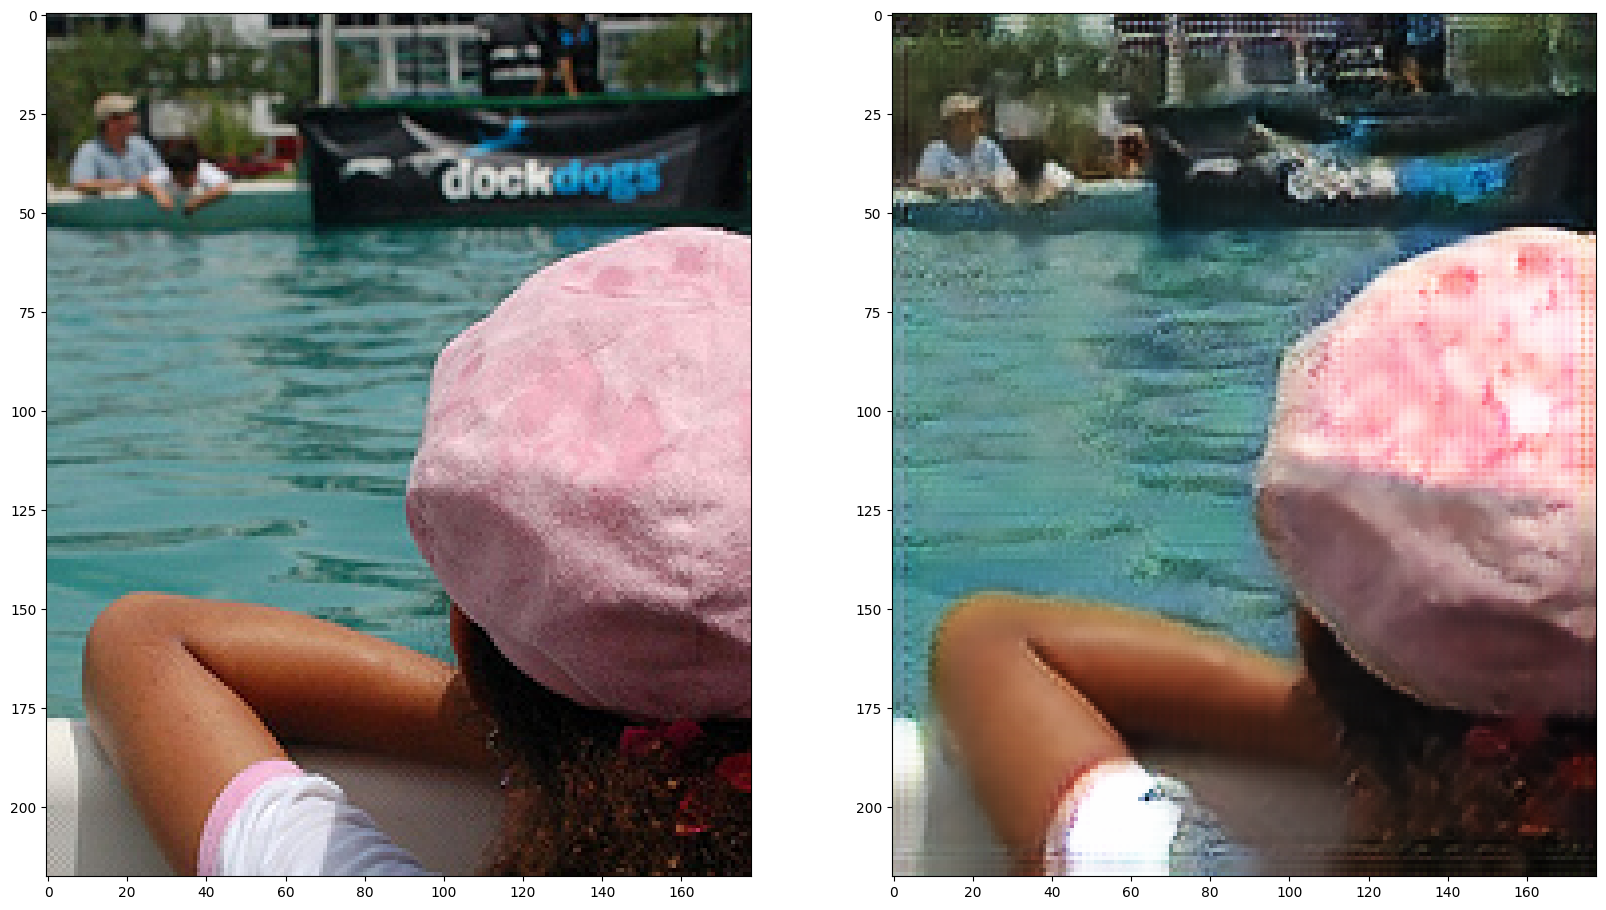

[6/7][50/1272]	Loss_D: 1.3577	Loss_G: 1.1524	Loss_E: 1.1493	D(x): 0.5237	D(G(z)): 0.5013 / 0.5010
[6/7][100/1272]	Loss_D: 1.3770	Loss_G: 1.1673	Loss_E: 1.1666	D(x): 0.4871	D(G(z)): 0.4770 / 0.4703
[6/7][150/1272]	Loss_D: 1.3745	Loss_G: 1.1072	Loss_E: 1.1092	D(x): 0.5010	D(G(z)): 0.4901 / 0.4927
[6/7][200/1272]	Loss_D: 1.3689	Loss_G: 1.1304	Loss_E: 1.1321	D(x): 0.5155	D(G(z)): 0.5024 / 0.5037
[6/7][250/1272]	Loss_D: 1.3668	Loss_G: 1.0874	Loss_E: 1.0880	D(x): 0.5003	D(G(z)): 0.4823 / 0.4929
[6/7][300/1272]	Loss_D: 1.3845	Loss_G: 1.0510	Loss_E: 1.0488	D(x): 0.4793	D(G(z)): 0.4739 / 0.4833
[6/7][350/1272]	Loss_D: 1.3506	Loss_G: 1.1397	Loss_E: 1.1393	D(x): 0.5118	D(G(z)): 0.4869 / 0.4742
[6/7][400/1272]	Loss_D: 1.3862	Loss_G: 1.2018	Loss_E: 1.2035	D(x): 0.5060	D(G(z)): 0.5034 / 0.4758
[6/7][450/1272]	Loss_D: 1.3573	Loss_G: 1.1487	Loss_E: 1.1504	D(x): 0.4910	D(G(z)): 0.4708 / 0.4823
[6/7][500/1272]	Loss_D: 1.3605	Loss_G: 1.0776	Loss_E: 1.0752	D(x): 0.5144	D(G(z)): 0.4940 / 0.4955


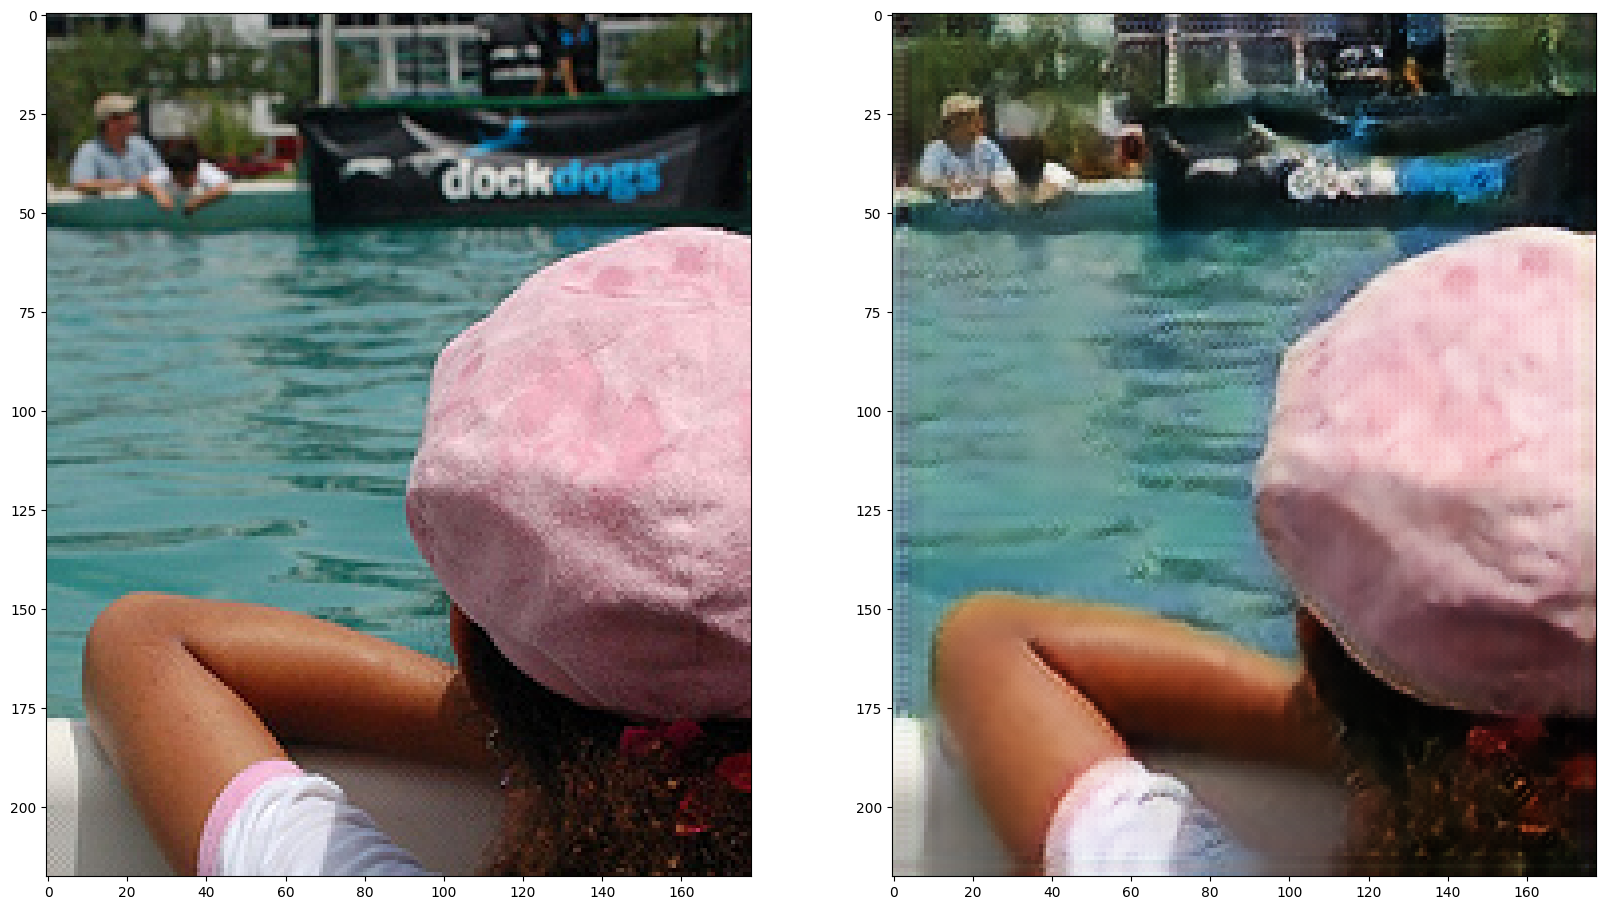

[6/7][550/1272]	Loss_D: 1.3725	Loss_G: 1.0991	Loss_E: 1.0992	D(x): 0.4775	D(G(z)): 0.4668 / 0.4684
[6/7][600/1272]	Loss_D: 1.3813	Loss_G: 1.1256	Loss_E: 1.1245	D(x): 0.4813	D(G(z)): 0.4742 / 0.4713
[6/7][650/1272]	Loss_D: 1.3805	Loss_G: 1.1072	Loss_E: 1.1037	D(x): 0.4977	D(G(z)): 0.4918 / 0.4903
[6/7][700/1272]	Loss_D: 1.3539	Loss_G: 1.0276	Loss_E: 1.0283	D(x): 0.5022	D(G(z)): 0.4778 / 0.4880
[6/7][750/1272]	Loss_D: 1.3779	Loss_G: 1.1202	Loss_E: 1.1213	D(x): 0.4703	D(G(z)): 0.4605 / 0.4687
[6/7][800/1272]	Loss_D: 1.3199	Loss_G: 1.1194	Loss_E: 1.1227	D(x): 0.5091	D(G(z)): 0.4632 / 0.4678
[6/7][850/1272]	Loss_D: 1.3693	Loss_G: 1.0980	Loss_E: 1.0981	D(x): 0.4932	D(G(z)): 0.4824 / 0.4862
[6/7][900/1272]	Loss_D: 1.3895	Loss_G: 1.0666	Loss_E: 1.0655	D(x): 0.5088	D(G(z)): 0.5081 / 0.4948
[6/7][950/1272]	Loss_D: 1.3900	Loss_G: 1.1470	Loss_E: 1.1487	D(x): 0.5097	D(G(z)): 0.5086 / 0.5019
[6/7][1000/1272]	Loss_D: 1.3389	Loss_G: 1.0487	Loss_E: 1.0473	D(x): 0.5357	D(G(z)): 0.5022 / 0.5247


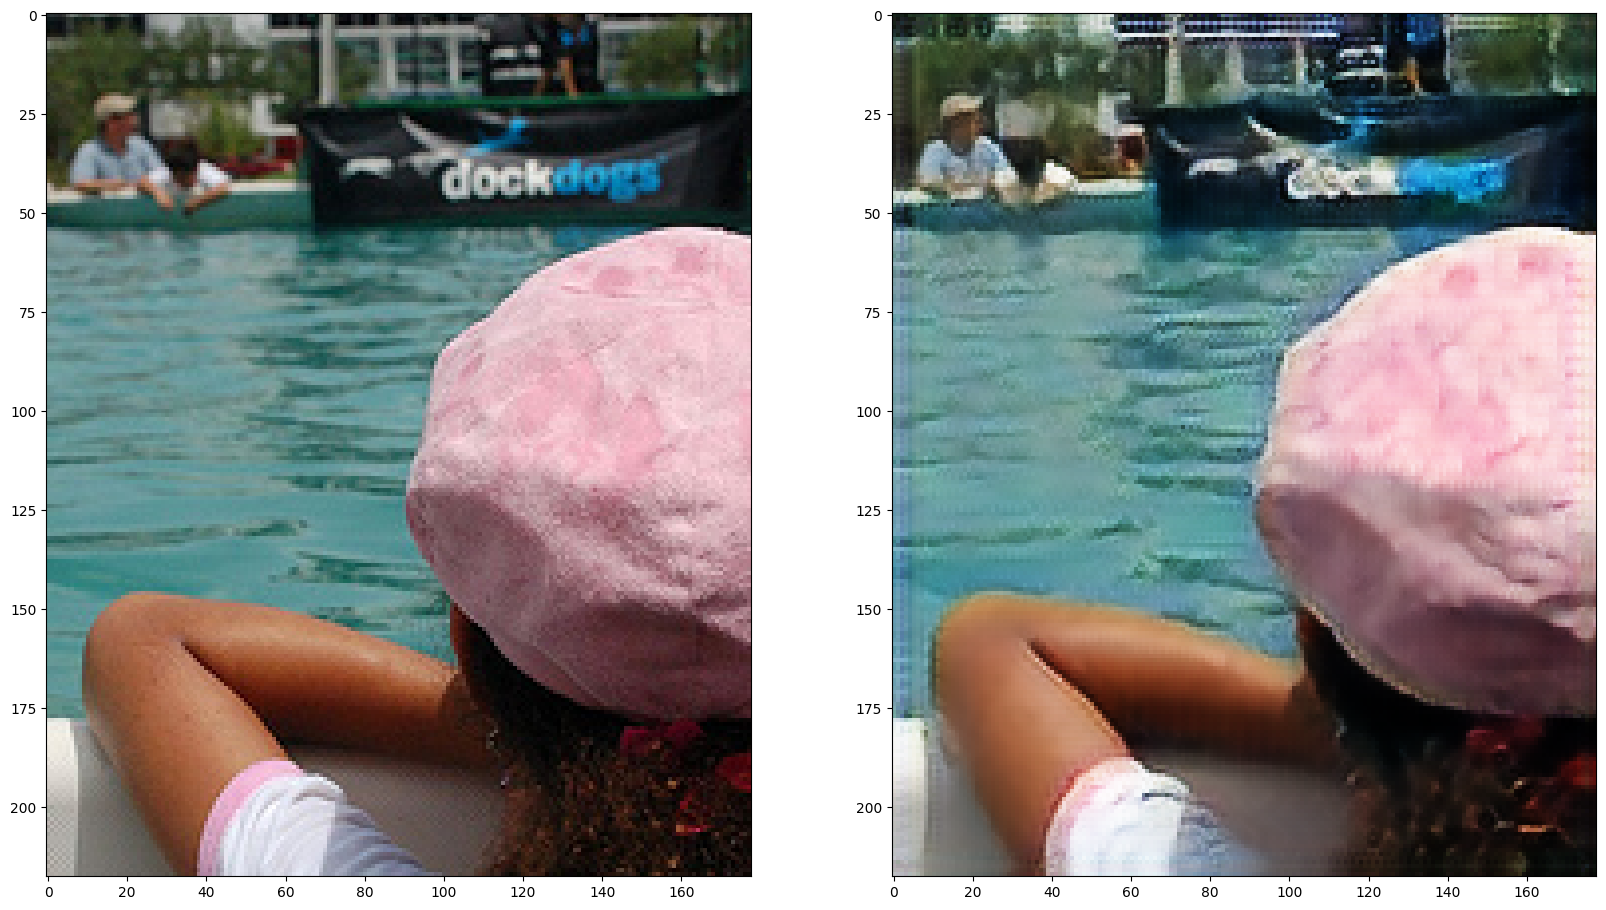

[6/7][1050/1272]	Loss_D: 1.3507	Loss_G: 1.1591	Loss_E: 1.1585	D(x): 0.5282	D(G(z)): 0.5063 / 0.4926
[6/7][1100/1272]	Loss_D: 1.4072	Loss_G: 1.1057	Loss_E: 1.1047	D(x): 0.5111	D(G(z)): 0.5192 / 0.5105
[6/7][1150/1272]	Loss_D: 1.3748	Loss_G: 1.0740	Loss_E: 1.0764	D(x): 0.4883	D(G(z)): 0.4798 / 0.4883
[6/7][1200/1272]	Loss_D: 1.3318	Loss_G: 1.0461	Loss_E: 1.0441	D(x): 0.5833	D(G(z)): 0.5391 / 0.5033
[6/7][1250/1272]	Loss_D: 1.3644	Loss_G: 1.1379	Loss_E: 1.1384	D(x): 0.4856	D(G(z)): 0.4681 / 0.4747


In [ ]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
E_losses = []
iters = 0
num_epochs = 7

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images) in enumerate(dataloader, 0):
        netG.train()
        netD.train()
        netE.train()
        
        netD.zero_grad()
        
        images = images.to(device)
        fake_images = netG(netE(images))
        # (1) Update D network: maximize the Gradient
        
        ## Create a fake pair batch --

        inp_x = {}
        inp_x['img']=images
        inp_x['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.855, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()
        
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        label = torch.FloatTensor(np.random.uniform(low=0.005, high=0.155, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)
        
        errG = criterion(output, label) + 4*l1criterion(images,fake_images)
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()
        optimizerG.step()

        
        netE.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)

        errE = criterion(output, label) + 4*l1criterion(images,fake_images)
        errE.backward(retain_graph=True)
        E_G_z2 = output.mean().item()
        optimizerE.step()
        
        #STATS
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_E: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(),errE.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        E_losses.append(errE.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        del images
        del inp_x_fake
        del inp_x
        del label
        del output
        torch.cuda.empty_cache()
        iters += 1
        
        
        # Plot images every 500 iterations
        if i%500 ==0:
            netE.eval()
            netG.eval()
            encoded_img = netE(valid_batch)
            reconstructed_img = netG(encoded_img)
            f, axarr = plt.subplots(num_images_to_show,2)
            for i in range(num_images_to_show):
                validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
                rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5 ) + 0.5
                axarr[0].imshow(validimg)
                axarr[1].imshow(rec_img)
                f.set_figheight(20)
                f.set_figwidth(20)
            plt.show()

In [ ]:
print("Evaluating the model ...")
netE.eval()
netG.eval()
tot_img_size = IMG_WIDTH * IMG_HEIGHT * 3

Evaluating the model ...


In [ ]:
valid_dataset = ImageData(is_train=False)
batch_size=20
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

In [ ]:
print(valid_batch.shape)
encoded_img = netE(valid_batch)
print(encoded_img.shape)
reconstructed_img = netG(encoded_img)
print(reconstructed_img.shape)

torch.Size([20, 3, 218, 178])
torch.Size([20, 8, 54, 44])
torch.Size([20, 3, 218, 178])


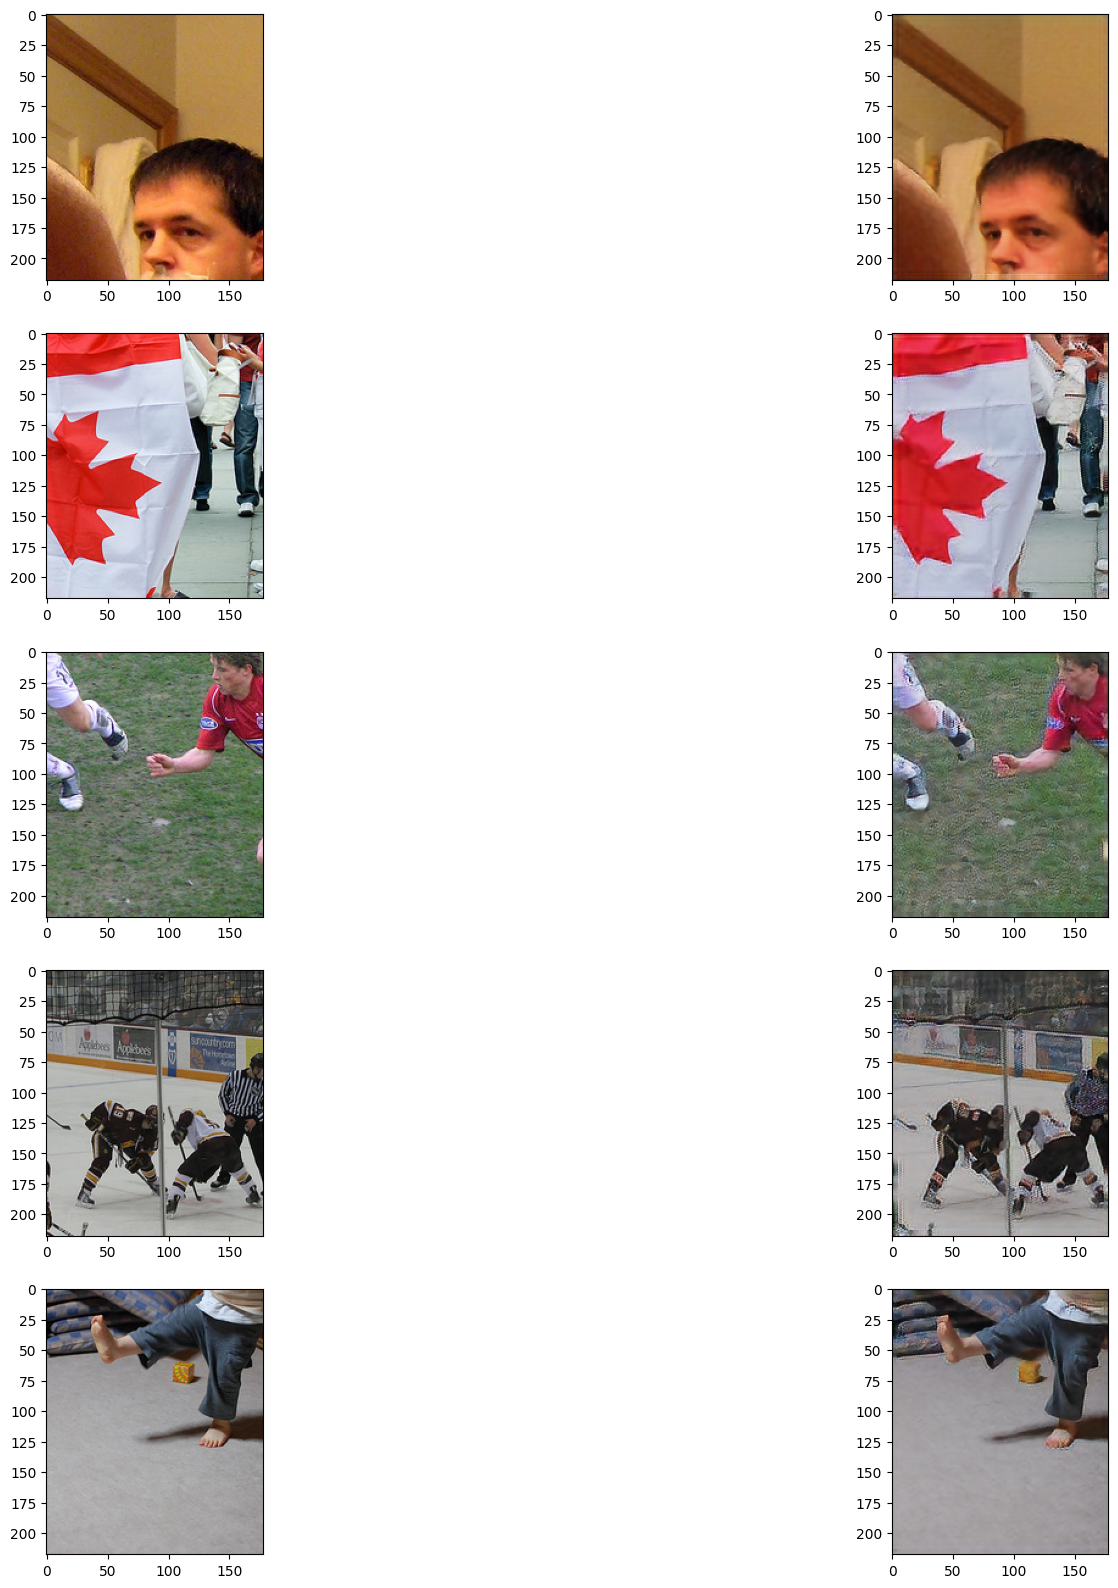

In [ ]:
num_images_to_show = 5
f, axarr = plt.subplots(num_images_to_show,2)
for i in range(num_images_to_show):
    validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
    rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5) + 0.5
    axarr[i,0].imshow(validimg)
    axarr[i,1].imshow(rec_img)
    f.set_figheight(20)
    f.set_figwidth(20)
plt.show()

In [ ]:
torch.save(netE.state_dict(), "netE"+str(num_channels_in_encoder)+".model")
torch.save(netG.state_dict(), "netG"+str(num_channels_in_encoder)+".model")

In [ ]:
print("Total no. of iterations = ",len(E_losses))
print("Mean Encoder loss = ",np.mean(E_losses))
print("Mean Generator loss = ",np.mean(G_losses))
print("Mean Discriminator loss = ",np.mean(D_losses))

Total no. of iterations =  8904
Mean Encoder loss =  1.2324298337530362
Mean Generator loss =  1.2323936372526787
Mean Discriminator loss =  1.3675844716201038


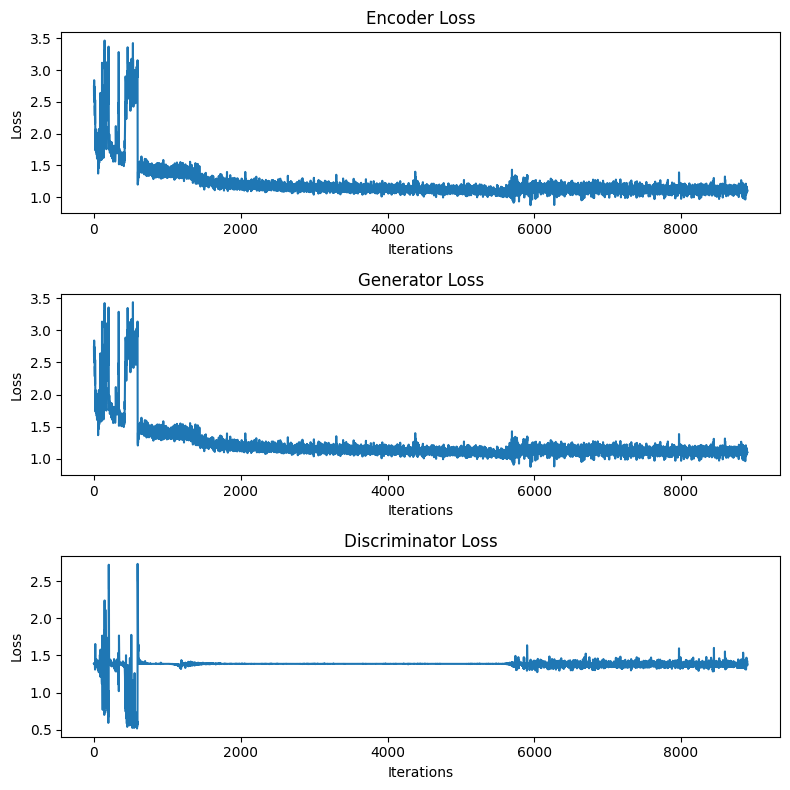

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

ax1.plot(E_losses)
ax1.set_title('Encoder Loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')

ax2.plot(G_losses)
ax2.set_title('Generator Loss')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')

ax3.plot(D_losses)
ax3.set_title('Discriminator Loss')
ax3.set_xlabel('Iterations')
ax3.set_ylabel('Loss')


plt.tight_layout()
plt.show()